# ANALYSE DES EFFETS DE LA METEOROLOGIE SUR L'AGRICULTURE DU SÉNÉGAL (2005-2023)

## OBJECTIFS :
──────────────

1. Analyser l'évolution du climat (température, précipitations)

2. Étudier les productions agricoles par culture

3. Analyser les rendements agricoles

4. QUANTIFIER l'effet du climat sur l'agriculture (CORRÉLATIONS)

5. Identifier les cultures vulnérables

6. Proposer des recommandations basées sur les données

##  STRUCTURE :
───────────────

PARTIE 1 : Vue d'ensemble et exploration

PARTIE 2 : Analyse climatique (2005-2023)

PARTIE 3 : Productions agricoles par culture

PARTIE 4 : Rendements agricoles

PARTIE 5 : Corrélations climat-agriculture  (CŒUR DE L'ANALYSE)

PARTIE 6 :  Effets des années de sécheresse sur les rendements agricoles par culture

PARTIE 7: Analyses comparatives et recommandations

Synthèse et conclusions

###  Configuration et importation des packages

In [0]:
# PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Statistiques
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau

# Machine Learning
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

#Numerotation des années
from matplotlib.ticker import MaxNLocator, FuncFormatter

print(" Toutes les bibliothèques chargées avec succès !")


 Toutes les bibliothèques chargées avec succès !


## PARTIE 1 : Vue d'ensemble et exploration

 Avant toute chose, il est nécessaire de comprendre la structure des données et avoir une vision globale :
   - Période couverte
   - Cultures présentes
   - Types d'éléments (Production, Rendement, Surface)
   - Statistiques climatiques de base

### 1.1 Chargement de la  table fusionnée annuelle

In [0]:

df_agri_climat = spark.table("annual_agri_climate_data")  
print("=== CHARGEMENT DES DONNÉES ===")
print(f"Nombre d'observations : {df_agri_climat.count()}")
print(f"Nombre de colonnes : {len(df_agri_climat.columns)}")
df_agri_climat.printSchema()

=== CHARGEMENT DES DONNÉES ===
Nombre d'observations : 2055
Nombre de colonnes : 11
root
 |-- Year: integer (nullable = true)
 |-- Item: string (nullable = true)
 |-- Element: string (nullable = true)
 |-- Unit: string (nullable = true)
 |-- Value: double (nullable = true)
 |-- dep_item: string (nullable = true)
 |-- dep_agri_value: long (nullable = true)
 |-- dep_agri_unit: string (nullable = true)
 |-- avg_temperature: double (nullable = true)
 |-- total_precipitation: double (nullable = true)
 |-- avg_pressure: double (nullable = true)



Les données utilisées proviennent de la table "annual_agri_climate_data" préalablement nettoyée et structurée(voir le notebook 05_Merge_datasets). Une vérification du volume ainsi que du schéma des données a été réalisée afin de garantir la cohérence des types de variables. Les variables climatiques et agricoles étant déjà correctement typées, aucune transformation ou conversion supplémentaire n’est donc nécessaire avant le lancement des analyses.

### 1.2 Cultures agricoles présentes

In [0]:

print(" 1.2 CULTURES PRÉSENTES DANS LES DONNÉES")
print("="*80)
cultures = df_agri_climat.select("Item").distinct().orderBy("Item")
nb_cultures = cultures.count()

print(f"Nombre total de cultures : {nb_cultures}")
print("\nListe des cultures :")
cultures.show(nb_cultures, truncate=False)

 1.2 CULTURES PRÉSENTES DANS LES DONNÉES
Nombre total de cultures : 37

Liste des cultures :
+------------------------------------------------------------------------+
|Item                                                                    |
+------------------------------------------------------------------------+
|Bananas                                                                 |
|Cabbages                                                                |
|Cantaloupes and other melons                                            |
|Carrots and turnips                                                     |
|Cashew nuts, in shell                                                   |
|Cassava, fresh                                                          |
|Chillies and peppers, dry (Capsicum spp., Pimenta spp.), raw            |
|Coconuts, in shell                                                      |
|Cow peas, dry                                                           |
|Eggpla

#### 1.3 Types d'éléments

In [0]:

print("\n 1.3 TYPES D'ÉLÉMENTS MESURÉS")
print("="*80)

elements = df_agri_climat.select("Element").distinct().orderBy("Element")
print("Types d'éléments disponibles :")
elements.show(truncate=False)

# Comptage par élément
element_counts =df_agri_climat.groupBy("Element").agg(
    count("*").alias("Nombre_Enregistrements")
).orderBy("Nombre_Enregistrements", ascending=False)

print("\nRépartition des enregistrements par type :")
element_counts.show()


 1.3 TYPES D'ÉLÉMENTS MESURÉS
Types d'éléments disponibles :
+--------------+
|Element       |
+--------------+
|Area harvested|
|Production    |
|Yield         |
+--------------+


Répartition des enregistrements par type :
+--------------+----------------------+
|       Element|Nombre_Enregistrements|
+--------------+----------------------+
|Area harvested|                   685|
|         Yield|                   685|
|    Production|                   685|
+--------------+----------------------+



Les données couvrent trois dimensions essentielles de l’activité agricole : la surface emblavée (Area harvested), la production totale et le rendement. Cette structure permet de distinguer clairement l’effet de l’extension des cultures, le volume produit et l’efficacité productive.
La parfaite équivalence du nombre d’observations pour chaque type d’élément assure une cohérence statistique de l’échantillon

## 1.4 Aperçu descriptif des variables climatiques (2005–2023)

In [0]:
print("\n 1.4 STATISTIQUES CLIMATIQUES (2005-2023)")
print("="*80)

stats_climat = df_agri_climat.select(
    "avg_temperature", 
    "total_precipitation", 
    "avg_pressure"
).describe()

print("Statistiques des variables climatiques :")
stats_climat.show()

# Valeurs remarquables
temp_min = df_agri_climat.select(min("avg_temperature")).first()[0]
temp_max = df_agri_climat.select(max("avg_temperature")).first()[0]
temp_moy = df_agri_climat.select(avg("avg_temperature")).first()[0]

precip_min = df_agri_climat.select(min("total_precipitation")).first()[0]
precip_max = df_agri_climat.select(max("total_precipitation")).first()[0]
precip_moy = df_agri_climat.select(avg("total_precipitation")).first()[0]

print(f"""
 RÉSUMÉ CLIMATIQUE :
   Température :
   - Minimum  : {temp_min:.2f}°C
   - Maximum  : {temp_max:.2f}°C
   - Moyenne  : {temp_moy:.2f}°C
   - Amplitude: {temp_max - temp_min:.2f}°C
   
   Précipitations annuelles :
   - Minimum  : {precip_min:.2f} mm
   - Maximum  : {precip_max:.2f} mm
   - Moyenne  : {precip_moy:.2f} mm
   - Amplitude: {precip_max - precip_min:.2f} mm
""")



 1.4 STATISTIQUES CLIMATIQUES (2005-2023)
Statistiques des variables climatiques :
+-------+-------------------+-------------------+-------------------+
|summary|    avg_temperature|total_precipitation|       avg_pressure|
+-------+-------------------+-------------------+-------------------+
|  count|               2055|               2055|               2055|
|   mean| 28.228732039180244|  4417.082627737207|  1011.314094963139|
| stddev|0.36163721908861113| 1766.8164638627761|0.13650154073246493|
|    min|  27.59651545036165| 1081.9999999999995| 1011.0515715593522|
|    max| 28.894520547945245|             8585.1|   1011.54409192467|
+-------+-------------------+-------------------+-------------------+


 RÉSUMÉ CLIMATIQUE :
   Température :
   - Minimum  : 27.60°C
   - Maximum  : 28.89°C
   - Moyenne  : 28.23°C
   - Amplitude: 1.30°C
   
   Précipitations annuelles :
   - Minimum  : 1082.00 mm
   - Maximum  : 8585.10 mm
   - Moyenne  : 4417.08 mm
   - Amplitude: 7503.10 mm



Cette section fournit une première compréhension globale des données climatiques utilisées dans l’étude, sans chercher encore à analyser des dynamiques ou des relations statistiques avancées.
Les résultats montrent un climat thermiquement stable, avec une température moyenne d’environ 28,2 °C et une faible amplitude interannuelle (≈ 1,3 °C), suggérant que la température varie peu sur la période étudiée. À l’inverse, les précipitations présentent une forte variabilité, avec une amplitude supérieure à 7 500 mm, traduisant une alternance marquée entre années humides et sèches.
La pression atmosphérique, quant à elle, reste très stable, ce qui confirme que la pluviométrie constitue le principal facteur de variabilité climatique susceptible d’influencer les rendements agricoles.

Maintenant que nous connaissons la structure des données, nous allons analyser
en détail l'évolution du CLIMAT sur la période 2005-2024.

Question : Comment le climat a-t-il évolué au Sénégal ces 19 années ?


##  PARTIE 2 : ANALYSE CLIMATIQUE  

L'analyse climatique est la base pour comprendre les impacts sur l'agriculture.
   Les tendances climatiques détectées ici seront corrélées aux rendements agricoles
   dans la Partie 5.

**OBJECTIFS** :
   1. Visualiser l'évolution des températures
   2. Visualiser l'évolution des précipitations
   3. Détecter les tendances (réchauffement, sécheresse)
   4. Identifier les années exceptionnelles (sécheresses, canicules   

### 2.1 Préparation : Données climatiques annuelles moyennes

 Pour plus de clarté, nous retenons une seule observation par année étant donné que les variables climatiques (température moyenne,précipitations totales et pression moyenne) sont identiques pour toutes les cultures au sein d’une même année, nous supprimons les doublons afin d’obtenir une valeur climatique unique par année.


In [0]:
print("\n🔧 2.1 PRÉPARATION DES DONNÉES CLIMATIQUES ANNUELLES")
print("="*80)

# Agrégation par année (une seule valeur par an)
df_climat_annuel = df_agri_climat.select("Year", "avg_temperature", "total_precipitation").distinct()

# Trier par année
df_climat_annuel = df_climat_annuel.orderBy("Year")

print(f" Données climatiques annuelles préparées : {df_climat_annuel.count()} années")

# Conversion en Pandas pour visualisation
climat_pandas = df_climat_annuel.toPandas()



🔧 2.1 PRÉPARATION DES DONNÉES CLIMATIQUES ANNUELLES
 Données climatiques annuelles préparées : 19 années


### 2.2 Evolution des températures (2005-2023)


 2.2 ÉVOLUTION DES TEMPÉRATURES (2005-2023)

📈 TENDANCE TEMPÉRATURE :
   Évolution : +0.0084°C par an
   R² : 0.016
   p-value : 0.6029
   
    Tendance non significative
   
    Variation totale sur 19 ans : +0.16°C



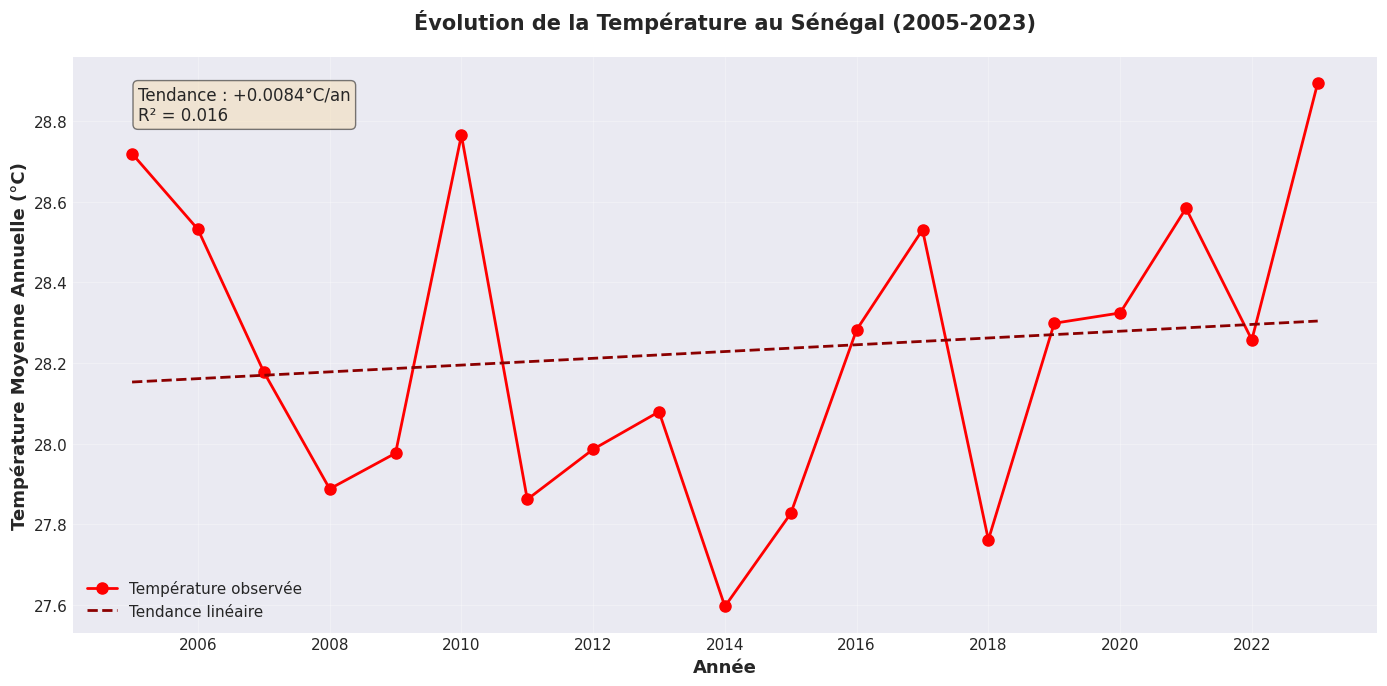

In [0]:

print("\n 2.2 ÉVOLUTION DES TEMPÉRATURES (2005-2023)")
print("="*80)

# Calcul de la tendance (régression linéaire)
slope_temp, intercept_temp, r_value_temp, p_value_temp, std_err_temp = stats.linregress(
    climat_pandas['Year'], 
    climat_pandas['avg_temperature']
)

print(f"""
📈 TENDANCE TEMPÉRATURE :
   Évolution : {slope_temp:+.4f}°C par an
   R² : {r_value_temp**2:.3f}
   p-value : {p_value_temp:.4f}
   
   {' Tendance statistiquement significative (p < 0.05)' if p_value_temp < 0.05 else ' Tendance non significative'}
   
    Variation totale sur 19 ans : {slope_temp * 19:+.2f}°C
""")

# Graphique : Évolution température
fig, ax = plt.subplots(figsize=(14, 7))

# Courbe des températures observées
ax.plot(climat_pandas['Year'], climat_pandas['avg_temperature'], 
        marker='o', linewidth=2, markersize=8, color='red', label='Température observée')

# Ligne de tendance
tendance_temp = intercept_temp + slope_temp * climat_pandas['Year']
ax.plot(climat_pandas['Year'], tendance_temp, 
        linestyle='--', linewidth=2, color='darkred', label='Tendance linéaire')

# Annotations
ax.set_xlabel('Année', fontsize=13, fontweight='bold')
ax.set_ylabel('Température Moyenne Annuelle (°C)', fontsize=13, fontweight='bold')
ax.set_title('Évolution de la Température au Sénégal (2005-2023)', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Ajouter texte avec la tendance
ax.text(0.05, 0.95, f'Tendance : {slope_temp:+.4f}°C/an\nR² = {r_value_temp**2:.3f}', 
        transform=ax.transAxes, fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x)}"))
plt.tight_layout()
plt.show()

L’évolution des températures moyennes annuelles au Sénégal montre une légère tendance haussière de +0,0084 °C par an, correspondant à une augmentation totale d’environ +0,16 °C sur 19 ans. Cette tendance demeure toutefois non significative sur le plan statistique (p-value = 0,60 ; R² = 0,016), ce qui indique l’absence d’un signal de réchauffement net sur la période considérée.

Certaines années se distinguent néanmoins par des anomalies marquées. Les températures les plus élevées sont observées en 2023 (≈ 28,9 °C) et 2010 (≈ 28,8 °C), tandis que les années les plus fraîches correspondent à 2014 (≈ 27,6 °C) et 2011 (≈ 27,9 °C). Ces contrastes illustrent une variabilité interannuelle modérée, mais sans évolution structurelle forte.

###  2.3 Évolution des précipitations


💧 2.3 ÉVOLUTION DES PRÉCIPITATIONS (2005-2023)

 TENDANCE PRÉCIPITATIONS :
   Évolution : +89.75 mm par an
   R² : 0.078
   p-value : 0.2459
   
    Tendance non significative
   
    Variation totale sur 19 ans : +1705 mm



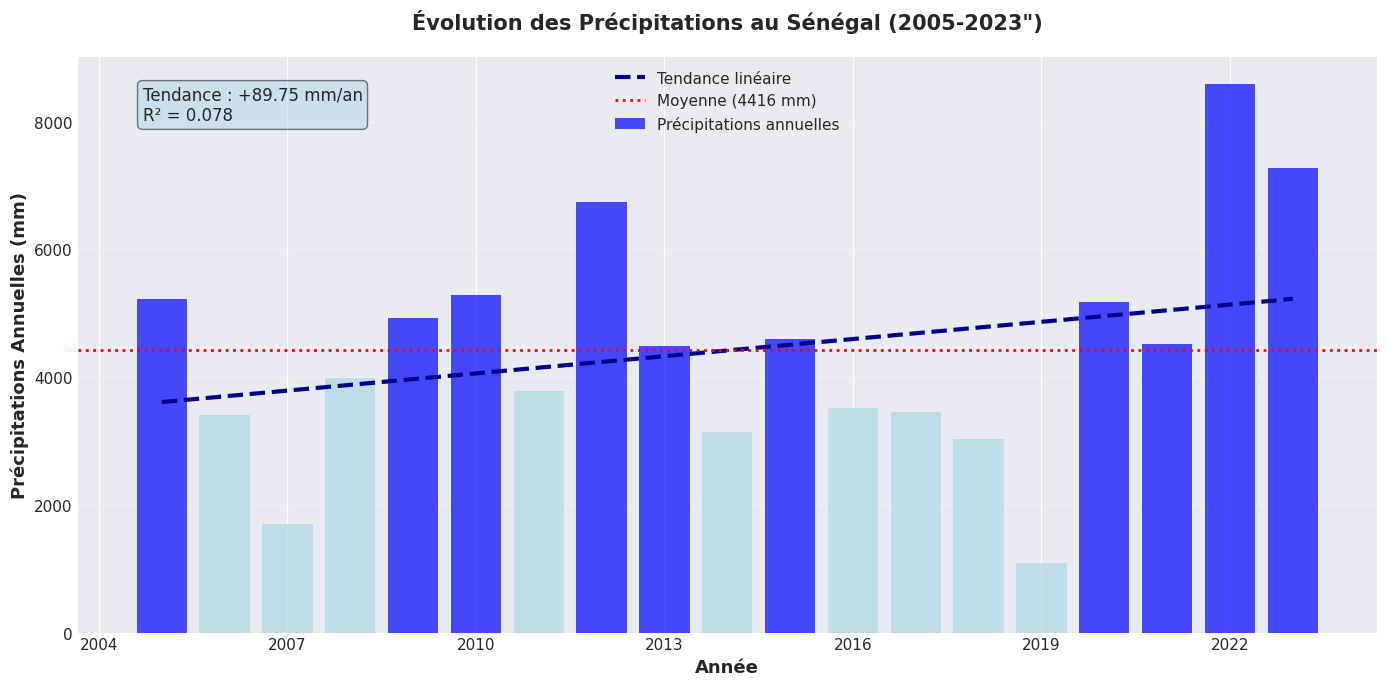

In [0]:
print("\n💧 2.3 ÉVOLUTION DES PRÉCIPITATIONS (2005-2023)")
print("="*80)

# Calcul de la tendance
slope_precip, intercept_precip, r_value_precip, p_value_precip, std_err_precip = stats.linregress(
    climat_pandas['Year'], 
    climat_pandas['total_precipitation']
)

print(f"""
 TENDANCE PRÉCIPITATIONS :
   Évolution : {slope_precip:+.2f} mm par an
   R² : {r_value_precip**2:.3f}
   p-value : {p_value_precip:.4f}
   
   {'Tendance statistiquement significative (p < 0.05)' if p_value_precip < 0.05 else ' Tendance non significative'}
   
    Variation totale sur 19 ans : {slope_precip * 19:+.0f} mm
""")

# Graphique : Évolution précipitations
fig, ax = plt.subplots(figsize=(14, 7))

# Barres des précipitations
colors = ['blue' if p > climat_pandas['total_precipitation'].mean() else 'lightblue' 
          for p in climat_pandas['total_precipitation']]
ax.bar(climat_pandas['Year'], climat_pandas['total_precipitation'], 
       color=colors, alpha=0.7, label='Précipitations annuelles')

# Ligne de tendance
tendance_precip = intercept_precip + slope_precip * climat_pandas['Year']
ax.plot(climat_pandas['Year'], tendance_precip, 
        linestyle='--', linewidth=3, color='darkblue', label='Tendance linéaire')

# Ligne moyenne
moyenne_precip = climat_pandas['total_precipitation'].mean()
ax.axhline(y=moyenne_precip, color='red', linestyle=':', linewidth=2, 
           label=f'Moyenne ({moyenne_precip:.0f} mm)')

# Annotations
ax.set_xlabel('Année', fontsize=13, fontweight='bold')
ax.set_ylabel('Précipitations Annuelles (mm)', fontsize=13, fontweight='bold')
ax.set_title('Évolution des Précipitations au Sénégal (2005-2023")', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Texte avec tendance
ax.text(0.05, 0.95, f'Tendance : {slope_precip:+.2f} mm/an\nR² = {r_value_precip**2:.3f}', 
        transform=ax.transAxes, fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x)}"))
plt.tight_layout()
plt.show()



L’analyse des précipitations annuelles au Sénégal met en évidence une tendance moyenne à la hausse estimée à +89,8 mm par an, soit une augmentation cumulée d’environ +1 705 mm sur 19 ans. Néanmoins, cette tendance reste statistiquement non significative (p-value = 0,25 ; R² = 0,078), indiquant une forte variabilité interannuelle qui masque toute évolution linéaire nette.

Certaines années se démarquent clairement par leurs extrêmes pluviométriques. Les années les plus humides sont 2022 (≈ 8 600 mm) et 2023 (≈ 7 300 mm), tandis que les années les plus sèches correspondent à 2019 (≈ 1 100 mm) et 2007 (≈ 1 700 mm). Ces contrastes soulignent une instabilité marquée du régime des pluies, avec une alternance d’années déficitaires et excédentaires.

Ainsi, contrairement à la température, la pluviométrie présente une variabilité beaucoup plus prononcée, ce qui en fait un facteur climatique clé pour l’analyse des rendements agricoles et des épisodes de stress hydrique.

###  2.4 Identification des années de sécheresse


 2.4 IDENTIFICATION DES ANNÉES DE sécheresse

 CRITÈRES DE SÉCHERESSE :
   Moyenne des précipitations : 4416 mm
   Écart-type : 1805 mm
   Seuil de sécheresse : 2612 mm
   
   Une année est considérée comme sèche si précipitations < 2612 mm


 ANNÉES DE SÉCHERESSE IDENTIFIÉES : 2
   • 2007 : 1702 mm (déficit de 910 mm)
   • 2019 : 1082 mm (déficit de 1530 mm)


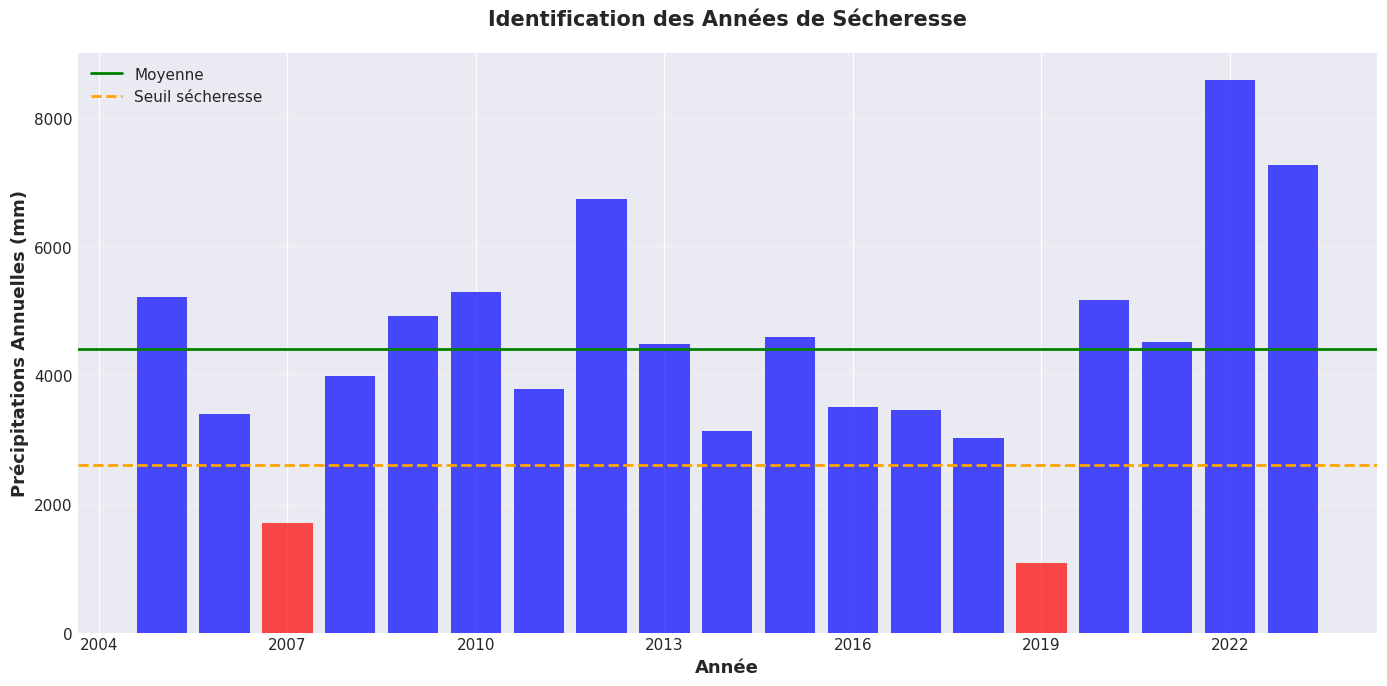

In [0]:

print("\n 2.4 IDENTIFICATION DES ANNÉES DE sécheresse")
print("="*80)

# Définition : Sécheresse = précipitations < (moyenne - 1 écart-type)
moyenne_precip = climat_pandas['total_precipitation'].mean()
std_precip = climat_pandas['total_precipitation'].std()
seuil_secheresse = moyenne_precip - std_precip

print(f"""
 CRITÈRES DE SÉCHERESSE :
   Moyenne des précipitations : {moyenne_precip:.0f} mm
   Écart-type : {std_precip:.0f} mm
   Seuil de sécheresse : {seuil_secheresse:.0f} mm
   
   Une année est considérée comme sèche si précipitations < {seuil_secheresse:.0f} mm
""")

# Identification des années sèches
annees_secheresse = climat_pandas[climat_pandas['total_precipitation'] < seuil_secheresse]

print(f"\n ANNÉES DE SÉCHERESSE IDENTIFIÉES : {len(annees_secheresse)}")
print("="*80)

if len(annees_secheresse) > 0:
    for idx, row in annees_secheresse.iterrows():
        deficit = seuil_secheresse - row['total_precipitation']
        print(f"   • {int(row['Year'])} : {row['total_precipitation']:.0f} mm (déficit de {deficit:.0f} mm)")
else:
    print("   Aucune année de sécheresse détectée selon ce critère")

# Graphique avec seuil de sécheresse
fig, ax = plt.subplots(figsize=(14, 7))

# Barres colorées selon sécheresse
colors = ['red' if p < seuil_secheresse else 'blue' for p in climat_pandas['total_precipitation']]
ax.bar(climat_pandas['Year'], climat_pandas['total_precipitation'], 
       color=colors, alpha=0.7)

# Lignes de référence
ax.axhline(y=moyenne_precip, color='green', linestyle='-', linewidth=2, label='Moyenne')
ax.axhline(y=seuil_secheresse, color='orange', linestyle='--', linewidth=2, label='Seuil sécheresse')

ax.set_xlabel('Année', fontsize=13, fontweight='bold')
ax.set_ylabel('Précipitations Annuelles (mm)', fontsize=13, fontweight='bold')
ax.set_title('Identification des Années de Sécheresse', fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x)}"))
plt.tight_layout()
plt.show()


Comme mis en évidence dans l’analyse de l’évolution des précipitations, les années 2007 et 2019 se distinguaient déjà par des niveaux de pluviométrie exceptionnellement faibles. L’application d’un critère statistique formel (précipitations inférieures à la moyenne moins un écart-type) confirme cette observation : ces deux années ne sont pas seulement parmi les plus sèches, elles sont les seules à être classées comme années de sécheresse sur l’ensemble de la période 2005–2023.

Avec des déficits respectifs de 910 mm en 2007 et 1 530 mm en 2019, ces épisodes représentent des chocs hydriques majeurs, susceptibles d’avoir affecté durablement la production et les rendements agricoles, aspects qui seront analysés dans la partie 6.

### 2.5 Matrice de corrélation climatique (Spearman)

<class 'pandas.core.frame.DataFrame'>


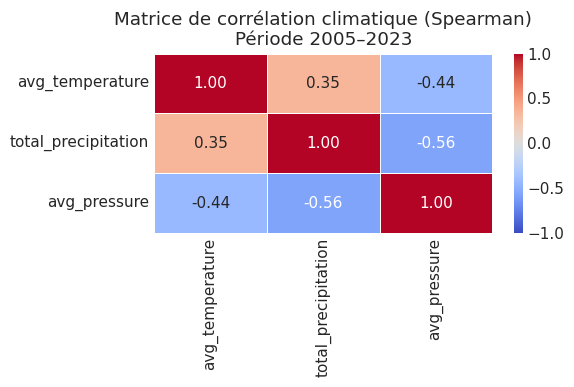

In [0]:

import matplotlib.pyplot as plt

# Variables climatiques
climate_vars = ['avg_temperature', 'total_precipitation', 'avg_pressure']



#  Conversion Spark → Pandas
df_agri_climat_pandas = df_agri_climat.toPandas()

# Vérifier que l’objet existe
print(type(df_agri_climat_pandas))

df_agri_climat_pandas[climate_vars] = df_agri_climat_pandas[climate_vars].apply(
    pd.to_numeric, errors='coerce'
)

# Calcul de la matrice de corrélation
corr_climat = df_agri_climat_pandas[climate_vars].dropna().corr(method='spearman')

# Visualisation
plt.figure(figsize=(6, 4))
sns.heatmap(
    corr_climat,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    linewidths=0.5
)
plt.title("Matrice de corrélation climatique (Spearman)\nPériode 2005–2023")
plt.tight_layout()
plt.show()


La matrice de corrélation de Spearman (2005–2023) met en évidence des relations climatiques cohérentes. La température moyenne est modérément et positivement corrélée aux précipitations totales (ρ = 0,35), suggérant que les années plus chaudes tendent à être légèrement plus humides. En revanche, la pression atmosphérique est négativement corrélée à la température (ρ = −0,44) et plus fortement aux précipitations (ρ = −0,56), indiquant que les épisodes pluvieux importants sont généralement associés à des situations de basses pressions. Ces interactions traduisent des mécanismes climatiques classiques et soulignent le rôle central de la pression atmosphérique dans la variabilité hydroclimatique observée

Nous avons maintenant une vision claire de l'évolution climatique :

   ✓ Tendance au réchauffement détectée

   ✓ Évolution des précipitations quantifiée

   ✓ Années de sécheresse identifiées

 Passons maintenant à l'analyse des production agricoles pour voir comment les cultures évoluent pendant cette même période.

## PARTIE 3 : PRODUCTIONS AGRICOLES 

Pour comprendre l’importance relative des différentes cultures dans l’agriculture sénégalaise, cette analyse vise à identifier les cultures les plus produites, à étudier l’évolution de leur production dans le temps et à détecter les tendances de croissance, de stagnation ou de déclin. Elle permet également de comparer les performances entre cultures et constitue une base essentielle pour l’analyse ultérieure de la relation entre la production agricole et les conditions climatiques.

###  3.1 Filtrage des données de production

In [0]:
print("\n 3.1 PRÉPARATION DES DONNÉES DE PRODUCTION")
print("="*80)

# Filtrer uniquement les enregistrements de "Production"
df_production = df_agri_climat.filter(col("Element") == "Production")

print(f" Enregistrements de production : {df_production.count():,}")
print(f" Cultures avec données de production : {df_production.select('Item').distinct().count()}")


 3.1 PRÉPARATION DES DONNÉES DE PRODUCTION
 Enregistrements de production : 685
 Cultures avec données de production : 37


### 3.2 Top 10 des cultures les plus produites


 3.2 TOP 10 DES CULTURES LES PLUS PRODUITES (2005-2023)
Top 10 des cultures :
+-----------------------------------------------+------------------------+---------------------------+-------------+
|Item                                           |Production_Totale_Tonnes|Production_Moyenne_Annuelle|Nombre_Annees|
+-----------------------------------------------+------------------------+---------------------------+-------------+
|Sugar cane                                     |2.04733242E7            |1077543.3789473684         |19           |
|Groundnuts, excluding shelled                  |1.967866981E7           |1035719.4636842104         |19           |
|Rice                                           |1.493934179E7           |786281.1468421052          |19           |
|Millet                                         |1.445440292E7           |760758.0484210526          |19           |
|Watermelons                                    |1.1482165E7             |604324.4736842106          |

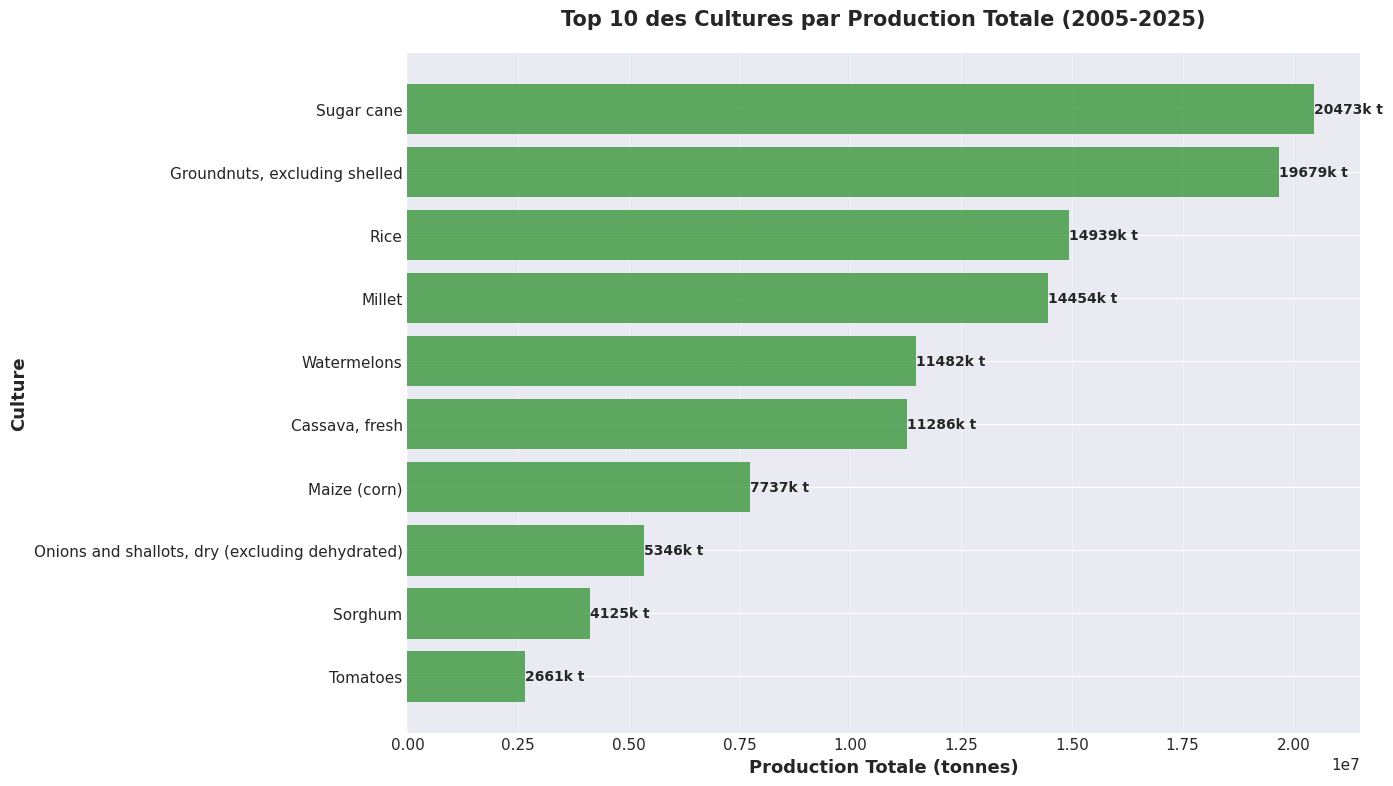

In [0]:
print("\n 3.2 TOP 10 DES CULTURES LES PLUS PRODUITES (2005-2023)")
print("="*80)

# Calcul de la production totale par culture sur toute la période
production_totale = df_production.groupBy("Item").agg(
    sum("Value").alias("Production_Totale_Tonnes"),
    avg("Value").alias("Production_Moyenne_Annuelle"),
    count("*").alias("Nombre_Annees")
).orderBy("Production_Totale_Tonnes", ascending=False)

print("Top 10 des cultures :")
production_totale.show(10, truncate=False)

# Conversion en Pandas pour graphique
top_10_pandas = production_totale.limit(10).toPandas()

# Graphique : Top 10 productions
fig, ax = plt.subplots(figsize=(14, 8))

bars = ax.barh(top_10_pandas['Item'], top_10_pandas['Production_Totale_Tonnes'], 
               color='forestgreen', alpha=0.7)

# Ajouter les valeurs sur les barres
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, 
            f'{width/1000:.0f}k t',
            ha='left', va='center', fontsize=10, fontweight='bold')

ax.set_xlabel('Production Totale (tonnes)', fontsize=13, fontweight='bold')
ax.set_ylabel('Culture', fontsize=13, fontweight='bold')
ax.set_title('Top 10 des Cultures par Production Totale (2005-2025)', 
             fontsize=15, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

plt.tight_layout()
plt.show()



Le graphique montre une forte concentration de la production agricole sur quelques cultures majeures sur la période 2005–2025. La canne à sucre et l’arachide dominent largement la production totale, suivies du riz et du mil, qui constituent des cultures de base essentielles. Les cultures vivrières comme le manioc, le maïs et le sorgho occupent une position intermédiaire, tandis que les cultures maraîchères, notamment l’oignon et la tomate, présentent des volumes plus faibles. Cette structure traduit à la fois l’importance des cultures de rente et le poids des céréales dans la sécurité alimentaire



###  3.3 Evolution de la production par culture

Pour plus de lisibilité des résultats et des visualisations, une analyse approfondie sera centrée sur les cinq premières cultures les plus produites, à savoir la canne à sucre (Sugar cane), l’arachide non décortiquée (Groundnuts, excluding shelled), le riz (Rice), le mil (Millet) et la pastèque (Watermelons).

In [0]:
print("Sélection des cultures stratégiques pour analyse détaillée")
cultures_top5 = top_10_pandas.head(5)['Item'].tolist()
cultures_a_analyser = cultures_top5

print(f"\n Cultures sélectionnées pour analyse détaillée : {len(cultures_a_analyser)}")
for i, culture in enumerate(cultures_a_analyser, 1):
    print(f"   {i}. {culture}")


Sélection des cultures stratégiques pour analyse détaillée

 Cultures sélectionnées pour analyse détaillée : 5
   1. Sugar cane
   2. Groundnuts, excluding shelled
   3. Rice
   4. Millet
   5. Watermelons



 3.3 EVOLUTION DE LA PRODUCTION DES 5 PREMIERES CULTURES


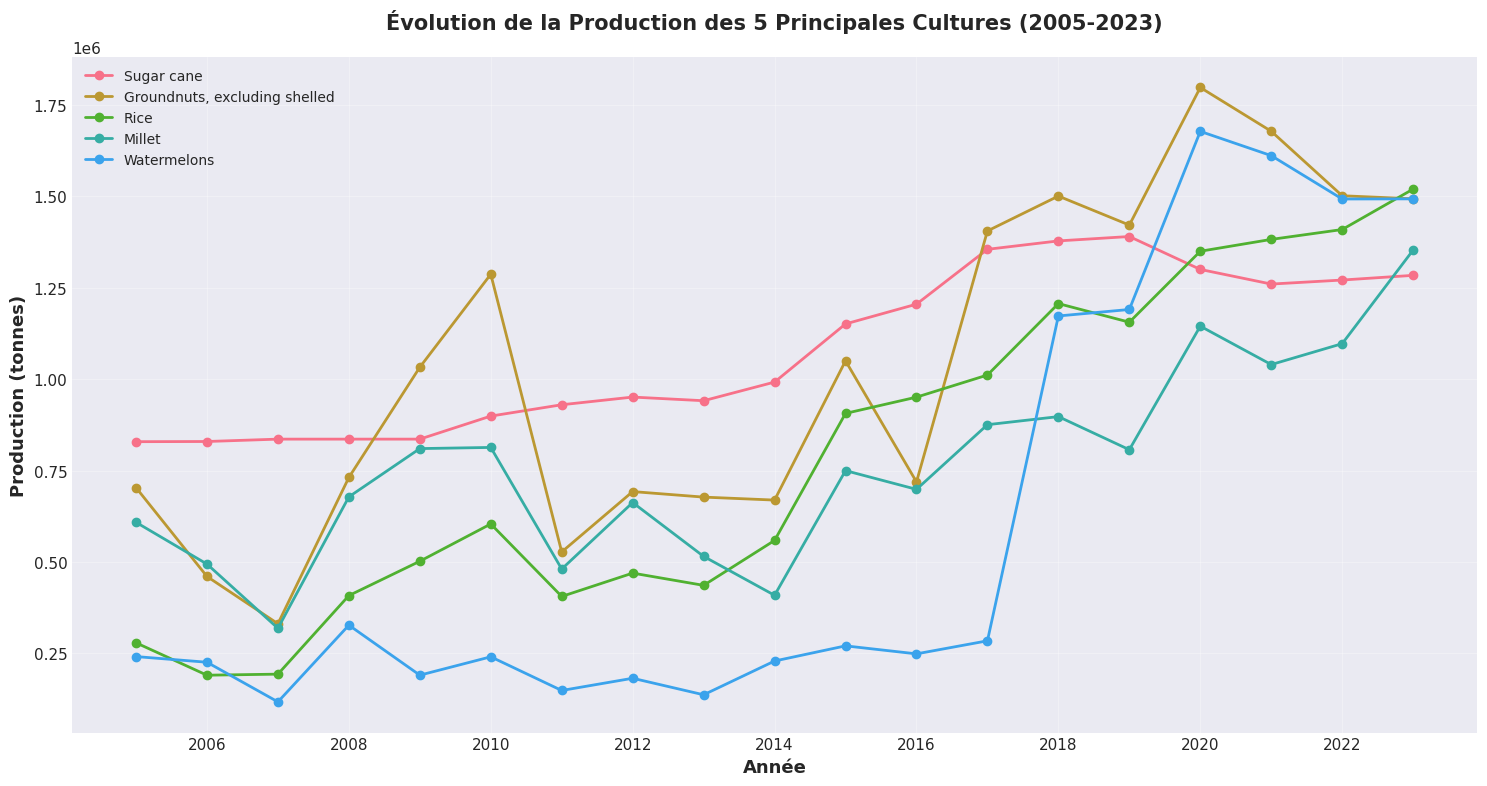

In [0]:
print("\n 3.3 EVOLUTION DE LA PRODUCTION DES 5 PREMIERES CULTURES")
print("="*80)

from matplotlib.ticker import MaxNLocator, FuncFormatter
# Filtrer les cultures sélectionnées
df_prod_principales = df_production.filter(col("Item").isin(cultures_a_analyser))

# Agrégation par année et culture
df_prod_evolution = df_prod_principales.groupBy("Year", "Item").agg(
    sum("Value").alias("Production")
).orderBy("Year", "Item")

# Conversion en Pandas
prod_evolution_pandas = df_prod_evolution.toPandas()

# Graphique : Évolution multi-cultures
fig, ax = plt.subplots(figsize=(15, 8))

for culture in cultures_a_analyser:
    data_culture = prod_evolution_pandas[prod_evolution_pandas['Item'] == culture]
    ax.plot(data_culture['Year'], data_culture['Production'], 
            marker='o', linewidth=2, markersize=6, label=culture)

ax.set_xlabel('Année', fontsize=13, fontweight='bold')
ax.set_ylabel('Production (tonnes)', fontsize=13, fontweight='bold')
ax.set_title('Évolution de la Production des 5 Principales Cultures (2005-2023)', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x)}"))

plt.show()


Le graphique met en évidence une hausse globale de la production agricole pour l’ensemble des cinq cultures entre 2005 et 2023, avec des dynamiques propres à chaque culture. La canne à sucre affiche une progression régulière et relativement stable sur l’ensemble de la période. Le riz et le mil connaissent une augmentation marquée à partir du milieu des années 2010, traduisant une intensification progressive de leur production. L’arachide présente des fluctuations plus importantes, alternant phases de forte croissance et replis ponctuels. Enfin, la pastèque se distingue par une production initialement faible, suivie d’une augmentation rapide et soutenue à partir de 2017, indiquant une expansion récente de cette culture.

###  3.4 Tendances de production des 5 cultures principales

In [0]:

print("\n 3.4 CALCUL DES TENDANCES DE PRODUCTION DES 5 CULTURES PRINCIPALESS")
print("="*80)

print("Culture                          | Tendance (t/an) | R²    | Signification")
print("-"*80)

tendances_production = {}

for culture in cultures_a_analyser:
    data_culture = prod_evolution_pandas[prod_evolution_pandas['Item'] == culture]
    
    if len(data_culture) > 2:  # Au moins 3 points pour régression
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            data_culture['Year'], 
            data_culture['Production']
        )
        
        tendances_production[culture] = {
            'slope': slope,
            'r2': r_value**2,
            'p_value': p_value
        }
        
        signif = " Significatif" if p_value < 0.05 else " Non significatif"
        print(f"{culture:32s} | {slope:+14.0f} | {r_value**2:.3f} | {signif}")




 3.4 CALCUL DES TENDANCES DE PRODUCTION DES 5 CULTURES PRINCIPALESS
Culture                          | Tendance (t/an) | R²    | Signification
--------------------------------------------------------------------------------
Sugar cane                       |         +35187 | 0.837 |  Significatif
Groundnuts, excluding shelled    |         +65116 | 0.644 |  Significatif
Rice                             |         +76863 | 0.924 |  Significatif
Millet                           |         +37160 | 0.605 |  Significatif
Watermelons                      |         +86589 | 0.669 |  Significatif


Ce tableau met en évidence une tendance générale à la hausse de la production pour l’ensemble des cinq cultures principales analysées. Le riz se distingue par la dynamique la plus robuste, avec une augmentation annuelle moyenne élevée et un coefficient de détermination très fort (R² = 0,924), traduisant une progression régulière et bien expliquée par la tendance temporelle. Les pastèques et l’arachide affichent également des croissances soutenues, quoique avec une variabilité plus marquée. La canne à sucre et le mil présentent des augmentations plus modérées, mais statistiquement significatives, suggérant une amélioration structurelle de la production sur la période étudiée. Globalement, la significativité des tendances confirme une expansion durable de la production agricole, malgré des rythmes et une stabilité variables selon les cultures.

## PARTIE 4 : RENDEMENTS AGRICOLES

Pourquoi s’intéresser aux rendements plutôt qu’aux seules productions totales ? Les rendements, exprimés en kilogrammes par hectare, permettent d’évaluer directement l’efficacité agricole en neutralisant l’effet des surfaces cultivées. Contrairement aux volumes produits, ils reflètent la productivité réelle des cultures et constituent ainsi un indicateur beaucoup plus pertinent pour analyser l’impact des conditions climatiques et établir des corrélations fiables entre climat et performance agricole.

**Objectifs** :
   1. Analyser les rendements moyens par culture
   2. Étudier l'évolution des rendements dans le temps
   3. Identifier les cultures les plus productives (kg/ha)
   4. Détecter les baisses de rendement

##  4.1 Filtrage des données de rendement

In [0]:
from pyspark.sql.functions import col

print("\n4.1 PRÉPARATION DES DONNÉES DE RENDEMENT (Serverless compatible)")
print("="*80)

# Filtrer uniquement les enregistrements de "Yield" (rendement)
df_rendement = df_agri_climat.filter(col("Element") == "Yield")


4.1 PRÉPARATION DES DONNÉES DE RENDEMENT (Serverless compatible)


##  4.2 Rendements moyens par culture


 4.2 RENDEMENTS MOYENS PAR CULTURE (2005-2023)
Rendements moyens des cultures principales :
+------------------------------------------------------------+---------------------+-------------+-------------+----------+---------------+
|Item                                                        |Rendement_Moyen_kg_ha|Rendement_Min|Rendement_Max|Ecart_Type|Nb_Observations|
+------------------------------------------------------------+---------------------+-------------+-------------+----------+---------------+
|Sugar cane                                                  |114667.81            |113373.5     |116760.6     |1038.64   |19             |
|Sweet potatoes                                              |35321.79             |25000.0      |45523.9      |7279.21   |19             |
|Onions and shallots, dry (excluding dehydrated)             |29077.04             |21333.3      |37500.0      |3396.79   |19             |
|Okra                                                        |26234

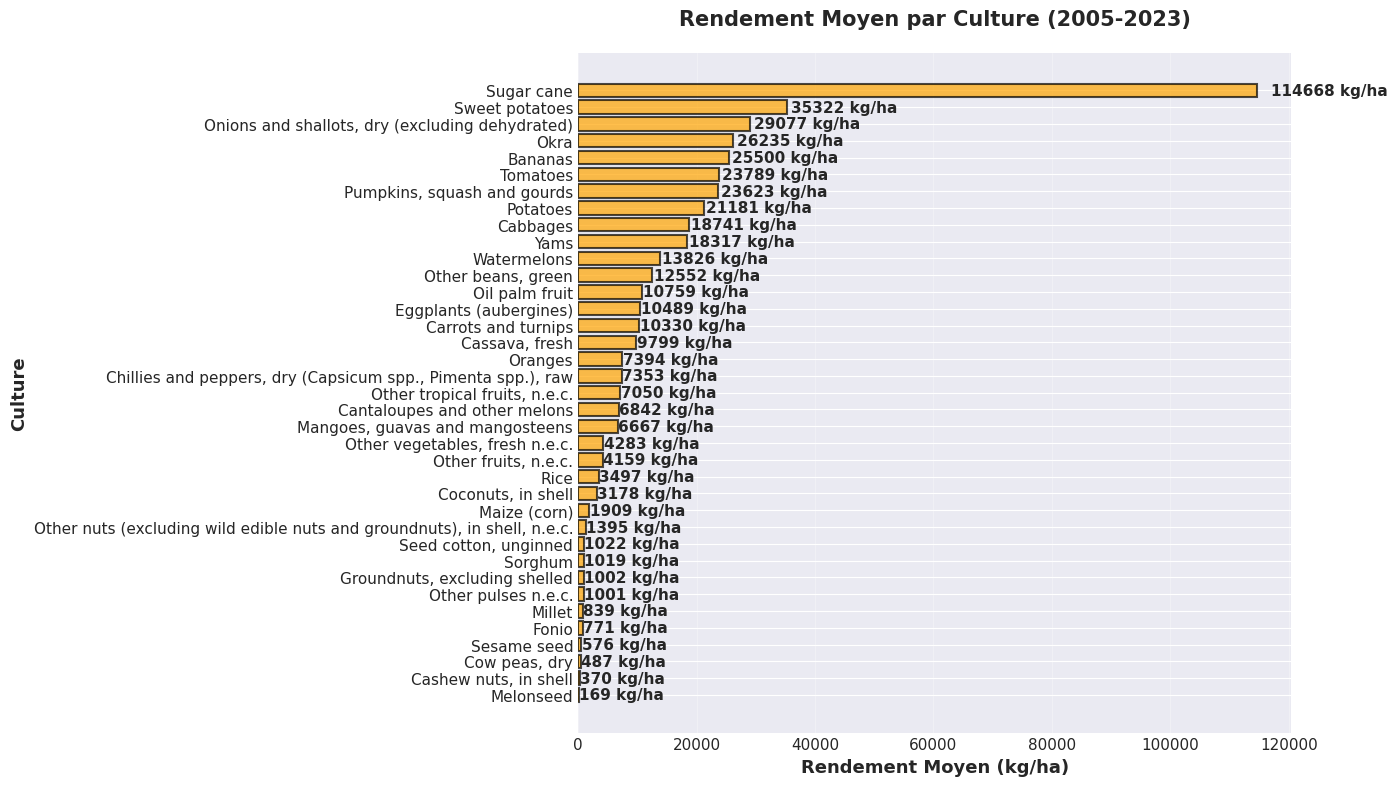


 Culture avec le MEILLEUR rendement : Sugar cane (114668 kg/ha)
 Culture avec le rendement le PLUS BAS : Melonseed (169 kg/ha)


In [0]:
print("\n 4.2 RENDEMENTS MOYENS PAR CULTURE (2005-2023)")
print("="*80)

# Calcul du rendement moyen par culture sur toute la période
rendements_moyens =df_rendement.groupby("Item").agg(
    round(avg("Value"), 2).alias("Rendement_Moyen_kg_ha"),
    round(min("Value"), 2).alias("Rendement_Min"),
    round(max("Value"), 2).alias("Rendement_Max"),
    round(stddev("Value"), 2).alias("Ecart_Type"),
    count("*").alias("Nb_Observations")
).orderBy("Rendement_Moyen_kg_ha", ascending=False)

print("Rendements moyens des cultures principales :")
rendements_moyens.show(truncate=False)

# Conversion en Pandas pour graphique
rend_moy_pandas = rendements_moyens.toPandas()

# COMMAND ----------
# Graphique : Rendements moyens
print("\n Visualisation des rendements moyens")

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(14, 8))

bars = ax.barh(rend_moy_pandas['Item'], rend_moy_pandas['Rendement_Moyen_kg_ha'], 
               color='orange', alpha=0.7, edgecolor='black', linewidth=1.5)

# Ajouter les valeurs sur les barres
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width + width*0.02, bar.get_y() + bar.get_height()/2, 
            f'{width:.0f} kg/ha',
            ha='left', va='center', fontsize=11, fontweight='bold')

ax.set_xlabel('Rendement Moyen (kg/ha)', fontsize=13, fontweight='bold')
ax.set_ylabel('Culture', fontsize=13, fontweight='bold')
ax.set_title('Rendement Moyen par Culture (2005-2023)', 
             fontsize=15, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\n Culture avec le MEILLEUR rendement : {rend_moy_pandas.iloc[0]['Item']} ({rend_moy_pandas.iloc[0]['Rendement_Moyen_kg_ha']:.0f} kg/ha)")
print(f" Culture avec le rendement le PLUS BAS : {rend_moy_pandas.iloc[-1]['Item']} ({rend_moy_pandas.iloc[-1]['Rendement_Moyen_kg_ha']:.0f} kg/ha)")



Ce graphique met en évidence une forte hétérogénéité des rendements moyens selon les cultures sur la période 2005–2023. La canne à sucre se distingue très nettement avec un rendement largement supérieur aux autres cultures, traduisant son caractère intensif et industriel. Les cultures maraîchères telles que la patate douce, l’oignon, l’okra, la banane ou la tomate affichent également des rendements élevés, reflétant une productivité importante par hectare. À l’inverse, les cultures céréalières et traditionnelles comme le mil, le sorgho, le maïs ou le fonio présentent des rendements plus faibles, tout comme certaines légumineuses et cultures de rente. Cette distribution souligne des différences structurelles de productivité agricole entre cultures, liées à leurs caractéristiques agronomiques et aux systèmes de production associés.

In [0]:
# Trier par rendement moyen décroissant et prendre les 10 premiers
top_10_pandas = rend_moy_pandas.sort_values(by="Rendement_Moyen_kg_ha", ascending=False).head(10)

# Extraire la liste des noms de cultures
top_10_cultures_par_rendement_moy = top_10_pandas['Item'].tolist()

print(" Top 10 des cultures par rendement moyen :")
for i, culture in enumerate(top_10_cultures_par_rendement_moy, 1):
    print(f"{i}. {culture}")


 Top 10 des cultures par rendement moyen :
1. Sugar cane
2. Sweet potatoes
3. Onions and shallots, dry (excluding dehydrated)
4. Okra
5. Bananas
6. Tomatoes
7. Pumpkins, squash and gourds
8. Potatoes
9. Cabbages
10. Yams


##  4.3 Évolution des rendements dans le temps


 4.3 ÉVOLUTION DES RENDEMENTS PAR CULTURE
 Données d'évolution préparées : 685 enregistrements

 Aperçu de l'évolution :

 Visualisation de l'évolution des rendements


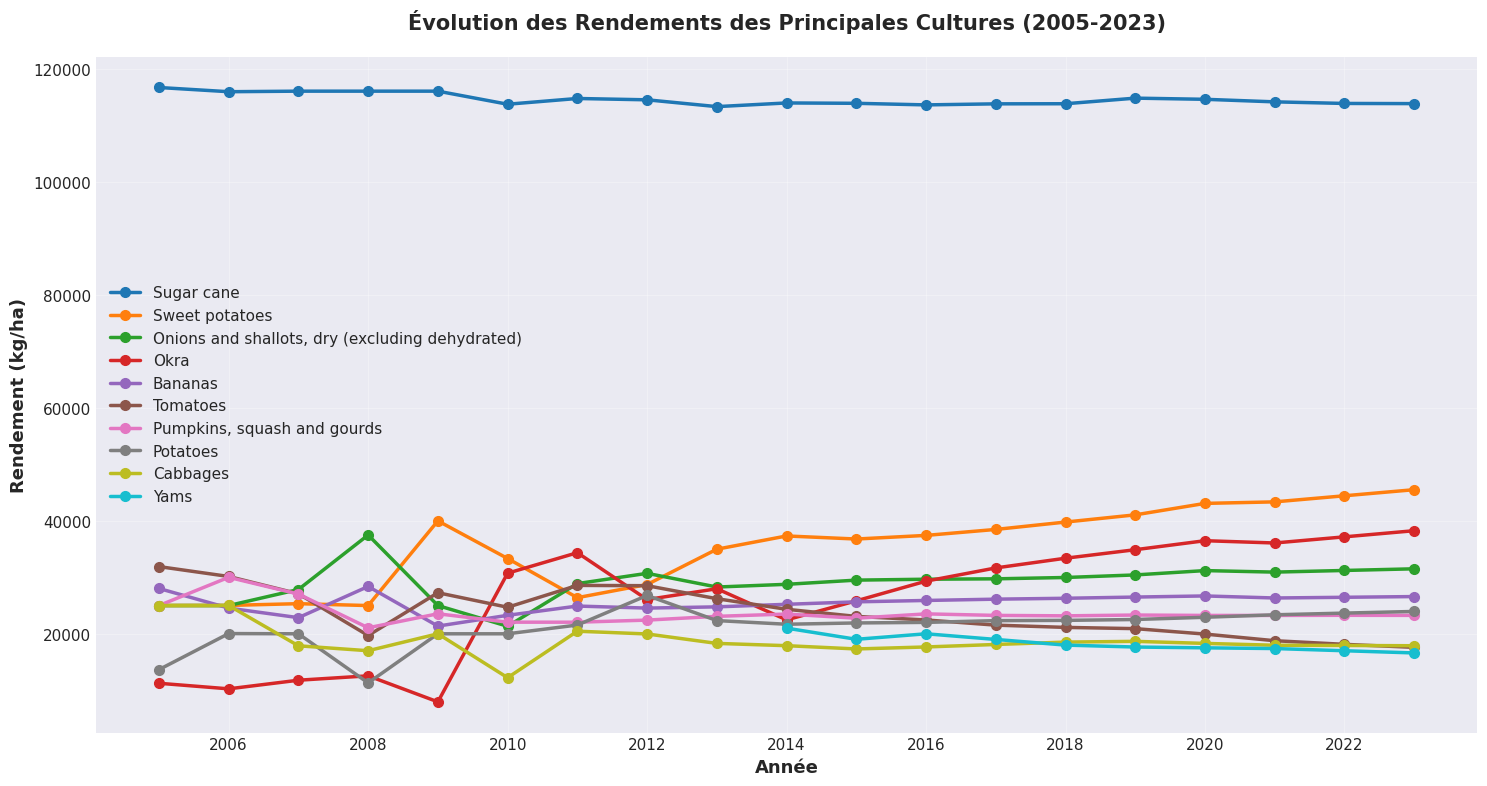

In [0]:
print("\n 4.3 ÉVOLUTION DES RENDEMENTS PAR CULTURE")
print("="*80)

# Agrégation par année et culture
df_rend_evolution = df_rendement.groupBy("Year", "Item").agg(
    avg("Value").alias("Rendement_kg_ha")
).orderBy("Year", "Item")

print(f" Données d'évolution préparées : {df_rend_evolution.count():,} enregistrements")

# Conversion en Pandas
rend_evolution_pandas = df_rend_evolution.toPandas()

print("\n Aperçu de l'évolution :")
rend_evolution_pandas.head(10)

# COMMAND ----------
# Graphique : Évolution des rendements multi-cultures
print("\n Visualisation de l'évolution des rendements")

fig, ax = plt.subplots(figsize=(15, 8))

# Couleurs différentes pour chaque culture
colors = plt.cm.tab10(np.linspace(0, 1, len(top_10_cultures_par_rendement_moy)))

for idx, culture in enumerate(top_10_cultures_par_rendement_moy):
    data_culture = rend_evolution_pandas[rend_evolution_pandas['Item'] == culture]
    if len(data_culture) > 0:
        ax.plot(data_culture['Year'], data_culture['Rendement_kg_ha'], 
                marker='o', linewidth=2.5, markersize=7, label=culture, color=colors[idx])

ax.set_xlabel('Année', fontsize=13, fontweight='bold')
ax.set_ylabel('Rendement (kg/ha)', fontsize=13, fontweight='bold')
ax.set_title('Évolution des Rendements des Principales Cultures (2005-2023)', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x)}"))
plt.show()



Le graphique montre des dynamiques de rendement contrastées selon les cultures sur la période 2005–2023. La canne à sucre affiche des rendements très élevés et globalement stables, avec de faibles fluctuations interannuelles. Les cultures maraîchères comme la patate douce, l’okra et l’oignon présentent une tendance globalement haussière, traduisant une amélioration progressive de leur productivité. À l’inverse, certaines cultures telles que l’igname, le chou ou la tomate montrent des variations plus marquées, avec des phases de baisse ou de stagnation selon les années. Globalement, le graphique met en évidence une évolution hétérogène des rendements, révélant des trajectoires spécifiques à chaque culture sur le long terme.

##  4.4 Calcul des tendances de rendement

In [0]:
print("\n 4.4 CALCUL DES TENDANCES DE RENDEMENT")
print("="*80)

from scipy import stats

# Agrégation par année et culture
df_rend_evolution = df_rendement.groupBy("Year", "Item").agg(
    avg("Value").alias("Rendement_kg_ha")
).orderBy("Year", "Item")

# Conversion en Pandas
rend_evolution_pandas = df_rend_evolution.toPandas()
print("\n ANALYSE DES TENDANCES (Régression Linéaire)")
print("="*100)
print("Culture                          | Tendance (kg/ha/an) | R²    | p-value   | Signification")
print("-"*100)

tendances_rendement = {}

for culture in top_10_cultures_par_rendement_moy:
    data_culture = rend_evolution_pandas[rend_evolution_pandas['Item'] == culture]
    
    if len(data_culture) > 2:
        # Régression linéaire : rendement = f(année)
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            data_culture['Year'], 
            data_culture['Rendement_kg_ha']
        )
        
        tendances_rendement[culture] = {
            'slope': slope,
            'intercept': intercept,
            'r2': r_value**2,
            'p_value': p_value,
            'r_value': r_value
        }
        
        # Interprétation
        signif = " SIGNIFICATIF" if p_value < 0.05 else " Non significatif"
        evolution = " Croissance" if slope > 0 else " Baisse"
        
        print(f"{culture:32s} | {slope:+18.2f} | {r_value**2:.3f} | {p_value:.5f} | {signif} {evolution}")




 4.4 CALCUL DES TENDANCES DE RENDEMENT

 ANALYSE DES TENDANCES (Régression Linéaire)
Culture                          | Tendance (kg/ha/an) | R²    | p-value   | Signification
----------------------------------------------------------------------------------------------------
Sugar cane                       |            -130.03 | 0.496 | 0.00076 |  SIGNIFICATIF  Baisse
Sweet potatoes                   |           +1160.37 | 0.805 | 0.00000 |  SIGNIFICATIF  Croissance
Onions and shallots, dry (excluding dehydrated) |            +272.60 | 0.204 | 0.05226 |  Non significatif  Croissance
Okra                             |           +1603.49 | 0.753 | 0.00000 |  SIGNIFICATIF  Croissance
Bananas                          |            +108.40 | 0.126 | 0.13522 |  Non significatif  Croissance
Tomatoes                         |            -638.73 | 0.702 | 0.00001 |  SIGNIFICATIF  Baisse
Pumpkins, squash and gourds      |            -129.80 | 0.139 | 0.11606 |  Non significatif  Baisse
Potatoe

Cette analyse des tendances de rendement met en évidence des dynamiques contrastées selon les cultures. Certaines cultures connaissent une amélioration significative des rendements, notamment la patate douce, le gombo et la pomme de terre, avec des coefficients de tendance élevés et des R² relativement forts, traduisant des gains de productivité réguliers et statistiquement robustes. À l’inverse, des baisses significatives de rendement sont observées pour la canne à sucre, la tomate et l’igname, suggérant des contraintes structurelles persistantes (pression climatique, dégradation des sols ou pratiques culturales). D’autres cultures, comme l’oignon, la banane, le chou ou les cucurbitacées, présentent des tendances non significatives, indiquant une évolution incertaine et fortement variable dans le temps. Globalement, ces résultats révèlent que la croissance de la production agricole ne repose pas uniquement sur l’extension des superficies, mais aussi sur des évolutions hétérogènes de la productivité, appelant à des politiques agricoles ciblées par culture.

### 4.5 Visualisation des tendances avec lignes de régression


 4.5 VISUALISATION DES TENDANCES AVEC LIGNES DE RÉGRESSION


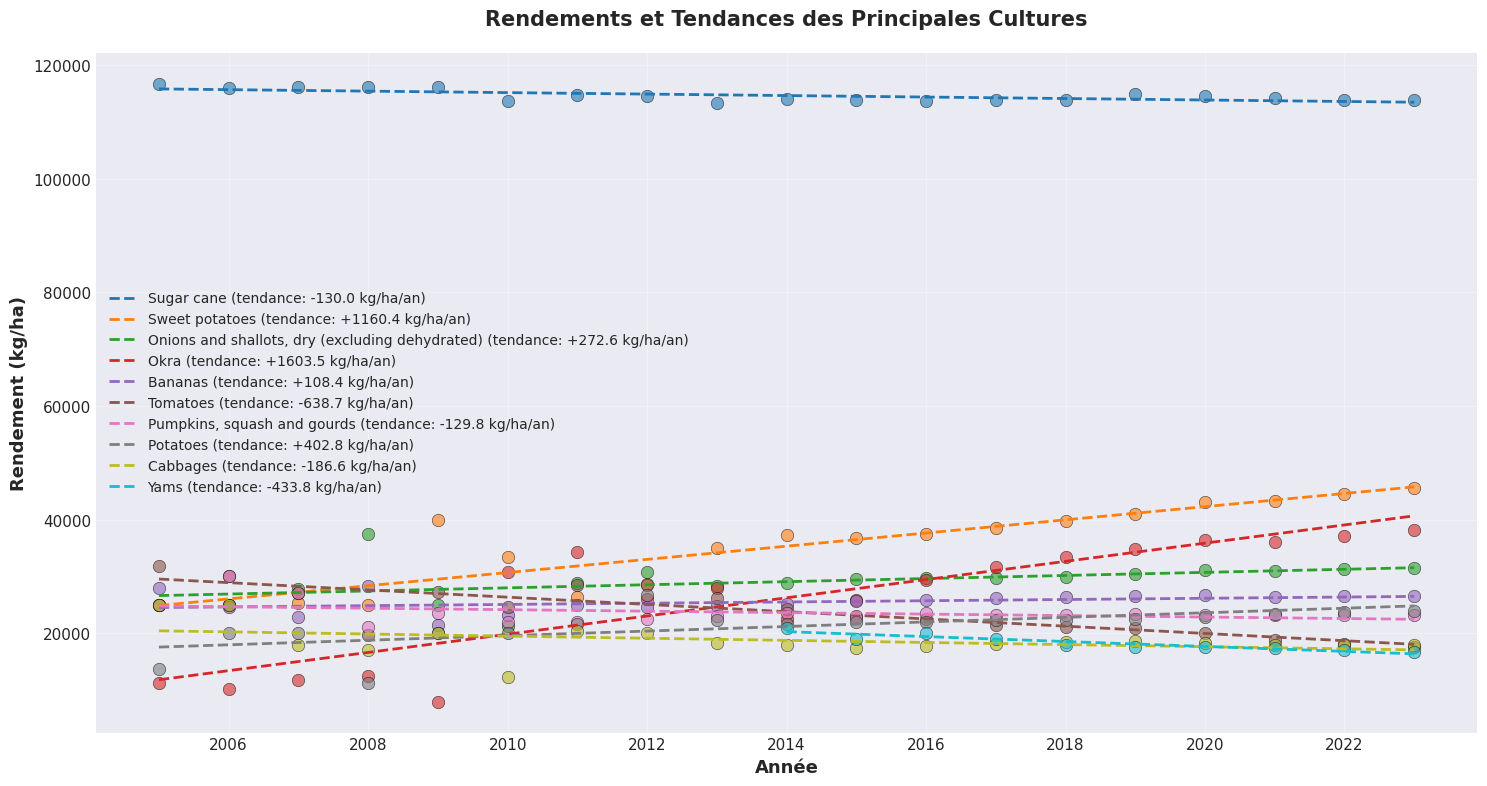

In [0]:

print("\n 4.5 VISUALISATION DES TENDANCES AVEC LIGNES DE RÉGRESSION")
print("="*80)

fig, ax = plt.subplots(figsize=(15, 8))

for idx, culture in enumerate(top_10_cultures_par_rendement_moy):
    data_culture = rend_evolution_pandas[rend_evolution_pandas['Item'] == culture]
    
    if len(data_culture) > 0 and culture in tendances_rendement:
        # Points réels
        ax.scatter(data_culture['Year'], data_culture['Rendement_kg_ha'], 
                   s=80, alpha=0.6, color=colors[idx], edgecolors='black', linewidth=0.5)
        
        # Ligne de tendance
        slope = tendances_rendement[culture]['slope']
        intercept = tendances_rendement[culture]['intercept']
        years = data_culture['Year'].values
        tendance = slope * years + intercept
        
        ax.plot(years, tendance, linestyle='--', linewidth=2, 
                color=colors[idx], label=f"{culture} (tendance: {slope:+.1f} kg/ha/an)")

ax.set_xlabel('Année', fontsize=13, fontweight='bold')
ax.set_ylabel('Rendement (kg/ha)', fontsize=13, fontweight='bold')
ax.set_title('Rendements et Tendances des Principales Cultures', 
             fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=10, loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x)}"))
plt.tight_layout()
plt.show()


Les résultats mettent en évidence une forte hétérogénéité des niveaux de rendement entre cultures, ainsi que des dynamiques d’évolution contrastées dans le temps. La canne à sucre se distingue nettement comme la culture la plus productive en niveau, avec des rendements très élevés et relativement stables sur l’ensemble de la période. Bien que sa tendance estimée soit légèrement négative, cette variation reste marginale au regard du niveau absolu du rendement, traduisant davantage une stagnation qu’un réel déclin de performance.

Un schéma similaire est observé pour certaines cultures à rendement intermédiaire, telles que la banane ou la tomate, dont les rendements restent globalement stables malgré de faibles tendances négatives. À l’inverse, plusieurs cultures, notamment l’okra et la patate douce, présentent des tendances positives marquées, indiquant une amélioration progressive de la productivité au fil du temps. Enfin, certaines cultures céréalières et vivrières comme le mil ou l’igname affichent des rendements plus faibles et des évolutions modestes, suggérant une productivité structurellement limitée.

Dans l’ensemble, ces résultats soulignent l’importance de distinguer le niveau de rendement (productivité intrinsèque) de la tendance temporelle (dynamique d’évolution).

### SYNTHESE :

In [0]:
print("\n Synthèse:")
print("-"*80)

# Culture avec meilleur rendement
meilleur = rend_moy_pandas.iloc[0]
print(f" Meilleur rendement moyen : {meilleur['Item']} ({meilleur['Rendement_Moyen_kg_ha']:.0f} kg/ha)")

# Cultures en croissance vs déclin
croissance = [c for c, t in tendances_rendement.items() if t['slope'] > 0]
declin = [c for c, t in tendances_rendement.items() if t['slope'] < 0]

print(f"\n Cultures en CROISSANCE : {len(croissance)}")
for c in croissance:
    print(f"   • {c} : +{tendances_rendement[c]['slope']:.1f} kg/ha/an")

print(f"\n Cultures en DÉCLIN : {len(declin)}")
for c in declin:
    print(f"   • {c} : {tendances_rendement[c]['slope']:.1f} kg/ha/an")



 Synthèse:
--------------------------------------------------------------------------------
 Meilleur rendement moyen : Sugar cane (114668 kg/ha)

 Cultures en CROISSANCE : 5
   • Sweet potatoes : +1160.4 kg/ha/an
   • Onions and shallots, dry (excluding dehydrated) : +272.6 kg/ha/an
   • Okra : +1603.5 kg/ha/an
   • Bananas : +108.4 kg/ha/an
   • Potatoes : +402.8 kg/ha/an

 Cultures en DÉCLIN : 5
   • Sugar cane : -130.0 kg/ha/an
   • Tomatoes : -638.7 kg/ha/an
   • Pumpkins, squash and gourds : -129.8 kg/ha/an
   • Cabbages : -186.6 kg/ha/an
   • Yams : -433.8 kg/ha/an


Après avoir exploré le contexte général (Partie 1), analysé l’évolution du climat entre 2005 et 2024 (Partie 2), étudié les productions agricoles par culture (Partie 3) puis examiné les rendements agricoles comme indicateur clé de performance (Partie 4), l’analyse entre désormais dans sa phase centrale.

## PARTIE 5 : Corrélations climat-agriculture (CŒUR DE L'ANALYSE)

 Cette partie vise à répondre à la question fondamentale : quel est l’impact du climat sur les rendements agricoles ? Elle consiste à mesurer, pour chaque culture, les corrélations entre les précipitations et les rendements ainsi qu’entre la température et les rendements, en s’appuyant sur le coefficient de corrélation de Spearman et de Kendall. Cette approche permet de quantifier précisément la force des relations climat–rendement, d’identifier les cultures les plus vulnérables aux variations climatiques et de démontrer scientifiquement l’influence du climat sur la productivité agricole, fournissant ainsi une base pour formuler et justifier des recommandations d’adaptation.


 

##   5.1 Matrice de corrélation de Spearman et  Kendall

###  5.1.1 Matrice de corrélation de Spearman 

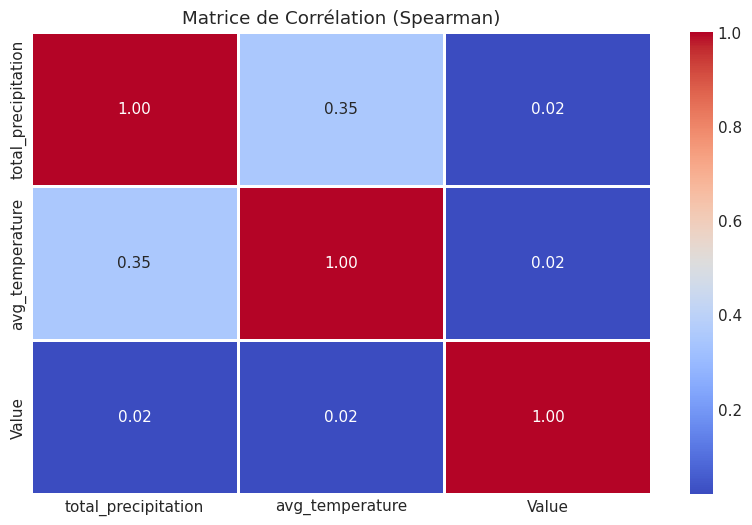

In [0]:


df_rendement_pandas=df_rendement.toPandas()
# Sélectionner uniquement les variables pertinentes
df_corr_pandas_selected = df_rendement_pandas[['total_precipitation', 'avg_temperature', 'Value']]

# Calcul des corrélations de Spearman
corr_matrix = df_corr_pandas_selected.corr(method='spearman')

# Affichage de la matrice de corrélation
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1)
plt.title("Matrice de Corrélation (Spearman)")
plt.show()


Les résultats de ce tableau de corrélations montrent que la relation entre les variables climatiques (température moyenne et précipitations totales) et la variable agricole (Value) est quasi inexistante (ρ ≈ 0,02 dans les deux cas). Cela indique qu’il n’y a pas de relation monotone directe et systématique entre les conditions climatiques annuelles moyennes et la performance agricole observée sur la période étudiée. 

###  5.1.2 Matrice de corrélation de Kendall

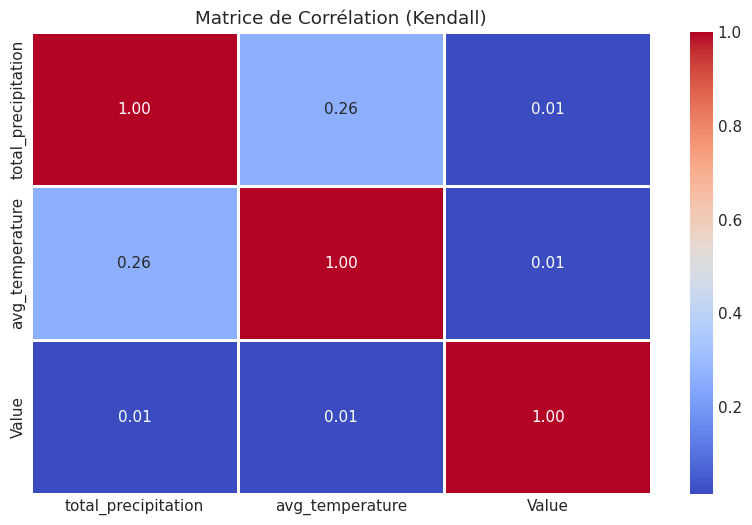

In [0]:

df_rendement_pandas=df_rendement.toPandas()
# Sélectionner uniquement les variables pertinentes
df_corr_pandas_selected = df_rendement_pandas[['total_precipitation', 'avg_temperature', 'Value']]

# Calcul des corrélations de Spearman
corr_matrix = df_corr_pandas_selected.corr(method='kendall')

# Affichage de la matrice de corrélation
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1)
plt.title("Matrice de Corrélation (Kendall)")
plt.show()


En se concentrant uniquement sur les corrélations climat–agriculture (méthode de Kendall), le constat est cohérent avec l’analyse de Spearman. Les coefficients entre la variable agricole (Value) et les précipitations totales (τ ≈ 0,01) ainsi qu’entre Value et la température moyenne (τ ≈ 0,01) sont quasi nuls, indiquant l’absence de relation monotone significative. Cela confirme que, sur la période étudiée, les variations globales de production ou de rendement ne sont pas directement expliquées par les fluctuations annuelles moyennes du climat. L’effet du climat sur l’agriculture apparaît donc indirect, hétérogène selon les cultures ou masqué par d’autres facteurs (pratiques agricoles, irrigation, surfaces cultivées), plutôt qu’observable via une corrélation globale simple.

Au regard des résultats précédents, les analyses globales de corrélation montrent que les relations climat–agriculture, lorsqu’elles sont étudiées de manière agrégée, restent faibles et peu significatives. Cette absence de lien clair ne signifie toutefois pas que le climat n’influence pas la production agricole, mais plutôt que cet effet est probablement différencié selon les cultures, leurs cycles biologiques et leurs exigences climatiques spécifiques. Il devient donc nécessaire de dépasser l’approche globale et d’adopter une analyse désagrégée par culture, afin d’identifier des sensibilités climatiques particulières qui peuvent être masquées dans les moyennes générales. C’est dans cette logique que s’inscrit la partie suivante, consacrée à l’étude des effets du climat sur chaque culture prise individuellement.

## 5.2 Effets du Climat sur les Rendements par Culture

Dans un premier temps, l’analyse se concentre sur le top 10 des cultures présentant les rendements moyens les plus élevés. Ce choix permet de cibler les cultures les plus productives et stratégiques, afin d’évaluer plus finement comment les variables climatiques (température et précipitations) influencent leurs performances, et d’identifier d’éventuelles sensibilités spécifiques au climat.

### 5.2.1 Corrélation climat-rendements du top 10 des cultures par rendement moyen

In [0]:



print("\n  Corrélation climat-rendements du top 10 des cultures par rendement moyen")
print("=" * 90)

resultats_corr = []

for culture in top_10_cultures_par_rendement_moy:
    data_culture = df_rendement_pandas[df_rendement_pandas["Item"] == culture].copy()

    x_precip = data_culture["total_precipitation"].values
    x_temp   = data_culture["avg_temperature"].values
    y        = data_culture["Value"].values

    # Conditions statistiques minimales
    if len(y) < 5 or np.std(y) == 0:
        print(f"{culture:30s} | Corrélation non calculable (variance insuffisante)")
        continue

    # ---------- SPEARMAN ----------
    rho_p, p_rho_p = spearmanr(x_precip, y)
    rho_t, p_rho_t = spearmanr(x_temp, y)

    # ---------- KENDALL ----------
    tau_p, p_tau_p = kendalltau(x_precip, y)
    tau_t, p_tau_t = kendalltau(x_temp, y)

    resultats_corr.append({
        "Culture": culture,

        "Spearman_Precip": rho_p,
        "p_Spearman_Precip": p_rho_p,

        "Spearman_Temp": rho_t,
        "p_Spearman_Temp": p_rho_t,

        "Kendall_Precip": tau_p,
        "p_Kendall_Precip": p_tau_p,

        "Kendall_Temp": tau_t,
        "p_Kendall_Temp": p_tau_t,

        "N_obs": len(y)
    })

# Résultats sous forme de DataFrame
df_corr_results = pd.DataFrame(resultats_corr)

print("\n Résumé des corrélations climat-rendement du top 10 des cultures classées par rendement moyen (Spearman & Kendall) :")
df_corr_results



  Corrélation climat-rendements du top 10 des cultures par rendement moyen

 Résumé des corrélations climat-rendement du top 10 des cultures classées par rendement moyen (Spearman & Kendall) :


,Culture,Spearman_Precip,p_Spearman_Precip,Spearman_Temp,p_Spearman_Temp,Kendall_Precip,p_Kendall_Precip,Kendall_Temp,p_Kendall_Temp,N_obs
0,Sugar cane,-0.114236,0.641454,-0.056239,0.819119,-0.082599,0.623497,-0.023600,0.888457,19
1,Sweet potatoes,0.217544,0.370970,0.191228,0.432903,0.122807,0.489338,0.134503,0.446735,19
2,"Onions and shallots, dry (excluding dehydrated)",0.202109,0.406663,-0.021090,0.931708,0.094399,0.574777,-0.023600,0.888457,19
3,Okra,0.240351,0.321602,0.278947,0.247479,0.157895,0.368004,0.216374,0.210923,19
4,Bananas,0.156140,0.523260,0.221053,0.363110,0.076023,0.678725,0.157895,0.368004,19
5,Tomatoes,-0.131579,0.591305,-0.142105,0.561693,-0.064327,0.730033,-0.122807,0.489338,19
6,"Pumpkins, squash and gourds",-0.263158,0.276359,0.268421,0.266510,-0.134503,0.446735,0.157895,0.368004,19
7,Potatoes,0.270651,0.262405,0.130053,0.595651,0.153398,0.361941,0.082599,0.623497,19
8,Cabbages,-0.094737,0.699657,0.007018,0.977254,-0.087719,0.628824,-0.029240,0.890267,19
9,Yams,-0.575758,0.081553,-0.636364,0.047912,-0.377778,0.155742,-0.511111,0.046623,10


Les résultats montrent que, pour la majorité des cultures de ce top 10, les corrélations entre les rendements et les variables climatiques (précipitations et température) sont faibles et statistiquement non significatives (p-value > 0,05). Cela suggère qu’à l’échelle annuelle et sur la période étudiée (2005-2023), les variations climatiques moyennes n’expliquent pas directement les fluctuations de rendement pour des cultures comme la canne à sucre, la patate douce, l’oignon, la banane, la tomate, la pomme de terre ou le chou. Ces cultures semblent soit relativement résilientes, soit davantage influencées par des facteurs non climatiques (pratiques agricoles, irrigation, intrants, variétés).

Un cas particulier se distingue : l’igname (Yams). Cette culture présente une corrélation négative modérée à forte et statistiquement significative avec la température (Spearman = −0.64, p ≈ 0.048 ; Kendall = −0.51, p ≈ 0.047). Cela indique qu’une augmentation de la température moyenne annuelle est associée à une baisse des rendements d’igname, suggérant une sensibilité climatique plus marquée.

###  5.2.2 Corrélation climat-rendements pour chacune des cultures

In [0]:


print("\n 5.2.2 Corrélation climat-rendements pour chacune des cultures ")
print("=" * 90)

#Liste des cultures
culture_a_analyser_rendement = df_rendement_pandas["Item"].unique().tolist()

resultats_corr = []

# Boucle sur les 10 meilleures cultures
for culture in culture_a_analyser_rendement:
    # Filtrer la culture sur toutes les années
    data_culture = df_rendement_pandas[df_rendement_pandas["Item"] == culture].copy()

    # Variables climatiques et rendement
    x_precip = data_culture["total_precipitation"].values
    x_temp   = data_culture["avg_temperature"].values
    y        = data_culture["Value"].values

    # Conditions statistiques minimales
    if len(y) < 5 or np.std(y) == 0:
        print(f"{culture:30s} | Corrélation non calculable (variance insuffisante)")
        continue

    # ---------- SPEARMAN ----------
    rho_p, p_rho_p = spearmanr(x_precip, y)
    rho_t, p_rho_t = spearmanr(x_temp, y)

    # ---------- KENDALL ----------
    tau_p, p_tau_p = kendalltau(x_precip, y)
    tau_t, p_tau_t = kendalltau(x_temp, y)

    # Stockage des résultats
    resultats_corr.append({
        "Culture": culture,
        "Spearman_Precip": rho_p,
        "p_Spearman_Precip": p_rho_p,
        "Spearman_Temp": rho_t,
        "p_Spearman_Temp": p_rho_t,
        "Kendall_Precip": tau_p,
        "p_Kendall_Precip": p_tau_p,
        "Kendall_Temp": tau_t,
        "p_Kendall_Temp": tau_t,
        "N_obs": len(y)
    })

# Résultats sous forme de DataFrame Pandas
df_corr_top10 = pd.DataFrame(resultats_corr)

# Affichage
print("\n✅ Corrélations climat-rendement pour toutes les  cultures (Spearman & Kendall) :")
df_corr_top10



 5.2.2 Corrélation climat-rendements pour chacune des cultures 

✅ Corrélations climat-rendement pour toutes les  cultures (Spearman & Kendall) :


,Culture,Spearman_Precip,p_Spearman_Precip,Spearman_Temp,p_Spearman_Temp,Kendall_Precip,p_Kendall_Precip,Kendall_Temp,p_Kendall_Temp,N_obs
0,Bananas,0.156140,0.523260,0.221053,0.363110,0.076023,0.678725,0.157895,0.157895,19
1,Cabbages,-0.094737,0.699657,0.007018,0.977254,-0.087719,0.628824,-0.029240,-0.029240,19
2,Cantaloupes and other melons,0.665903,0.035552,0.536602,0.109784,0.529150,0.043631,0.478755,0.478755,10
3,Carrots and turnips,-0.019332,0.937388,-0.133568,0.585660,-0.011800,0.944091,-0.094399,-0.094399,19
4,"Cashew nuts, in shell",0.256253,0.289618,0.094778,0.699531,0.187684,0.262618,0.070382,0.070382,19
5,"Cassava, fresh",0.357895,0.132460,0.329825,0.167887,0.263158,0.124797,0.251462,0.251462,19
6,"Chillies and peppers, dry (Capsicum spp., Pime...",0.215789,0.374935,0.507018,0.026719,0.134503,0.446735,0.356725,0.356725,19
7,"Coconuts, in shell",-0.130759,0.593638,-0.204476,0.401073,-0.058651,0.726286,-0.140763,-0.140763,19
8,"Cow peas, dry",0.173684,0.477017,0.335088,0.160799,0.064327,0.730033,0.263158,0.263158,19
9,Eggplants (aubergines),0.080737,0.742481,0.565160,0.011685,0.035191,0.833635,0.398829,0.398829,19


L’analyse des corrélations climat–rendement menée sur l’ensemble des cultures confirme d’abord que, de manière générale, les relations entre les variables climatiques moyennes annuelles (précipitations et température) et les rendements agricoles restent faibles et majoritairement non significatives, comme cela avait déjà été observé pour le top 10 des cultures par rendement moyen. Pour de nombreuses cultures, les coefficients de Spearman et de Kendall sont proches de zéro, avec des p-values élevées, ce qui indique l’absence de relation monotone claire à l’échelle annuelle. Toutefois, l’élargissement de l’analyse à toutes les cultures apporte un surplus d’information essentiel : il met en évidence une forte hétérogénéité des réponses climatiques. Certaines cultures présentent des corrélations statistiquement significatives qui n’apparaissaient pas clairement dans le top 10. C’est notamment le cas du maïs et du millet, dont les rendements sont positivement et significativement corrélés aux précipitations, et pour le maïs également à la température, suggérant une dépendance accrue aux conditions climatiques favorables. À l’inverse, l’igname (yams) se distingue par une corrélation négative significative avec la température, indiquant une vulnérabilité particulière au réchauffement. D’autres cultures, notamment certaines maraîchères et fruitières (aubergines, piments/poivrons secs, melons), montrent aussi des sensibilités spécifiques, positives ou négatives, vis-à-vis de la température ou des précipitations, bien que parfois sur des effectifs plus réduits. Comparativement, les cultures très productives et dominantes comme la canne à sucre, le manioc ou les bananes restent faiblement corrélées au climat, ce qui suggère une résilience plus élevée ou un rôle important des pratiques agronomiques (irrigation, techniques culturales, variétés améliorées). Ainsi, par rapport à l’analyse limitée au top 10, l’étude exhaustive révèle que le rendement élevé n’implique pas nécessairement une forte sensibilité climatique, tandis que des cultures secondaires peuvent être nettement plus exposées aux variations climatiques. Cette diversité de comportements confirme que l’impact du climat sur l’agriculture ne peut être appréhendé uniquement de manière globale et justifie pleinement la poursuite de l’analyse culture par culture, afin d’identifier précisément les cultures les plus vulnérables et celles qui sont les plus résilientes face aux changements climatiques.

### 5.3-Correlation des variables climatiques et depenses en agriculture par culture

Sur la période 2017–2023, l’analyse vise à explorer les relations entre les variables climatiques et la valeur agricole par culture. Compte tenu de la courte fenêtre temporelle et du caractère agrégé des données économiques, l’étude ne cherche pas à établir une causalité stricte, mais à identifier des associations robustes et des mécanismes explicatifs plausibles entre le climat et la performance agricole.

#### 5.3.1. Filtrage période 2017–2023

In [0]:
df_2017_2023 = df_agri_climat_pandas[
    (df_agri_climat_pandas['Year'] >= 2017) &
    (df_agri_climat_pandas['Year'] <= 2023)
].copy()


#### 5.3.2. Sélection et sécurisation des variables

In [0]:
vars_corr = ['dep_agri_value', 'avg_temperature', 'total_precipitation']

df_2017_2023[vars_corr] = df_2017_2023[vars_corr].apply(
    pd.to_numeric, errors='coerce'
)


#### 5.3.3 Matrice de corrélation Spearman par culture

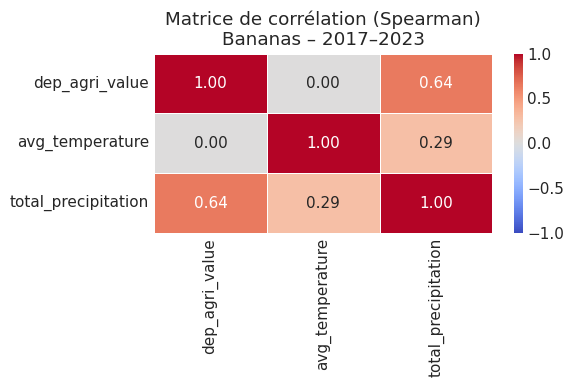

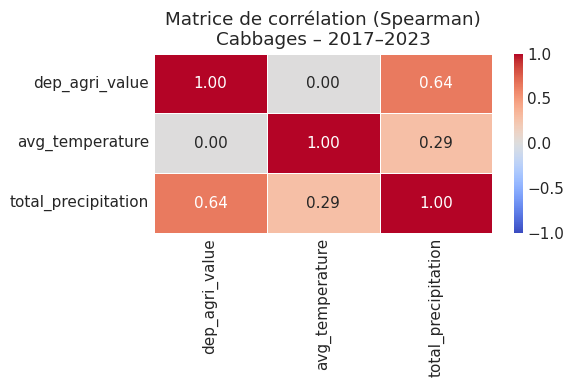

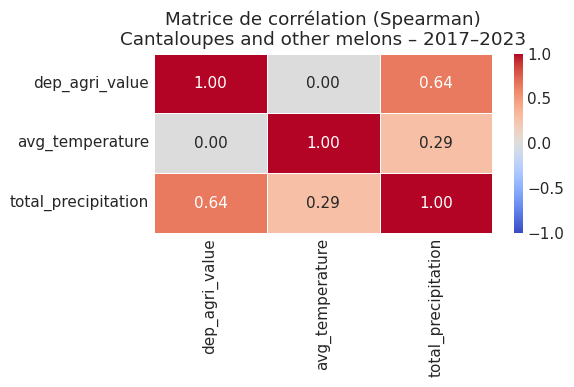

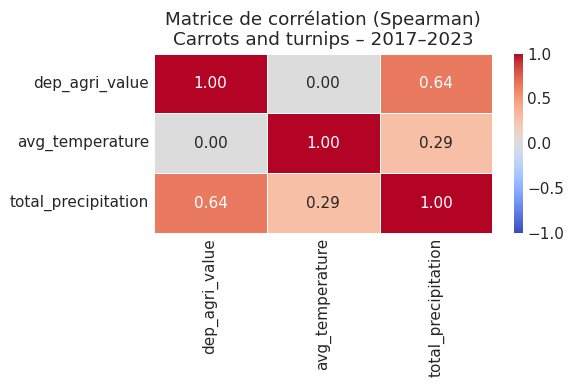

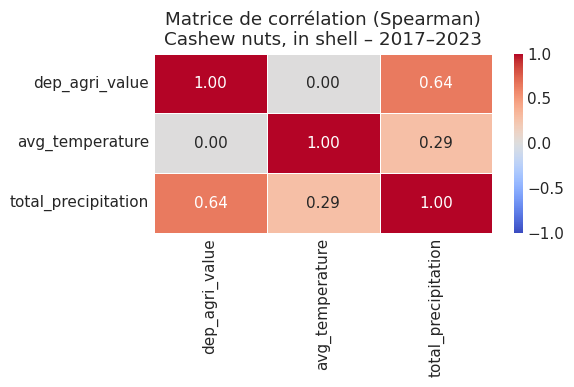

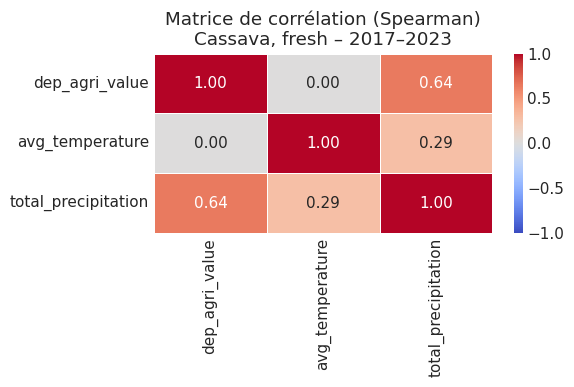

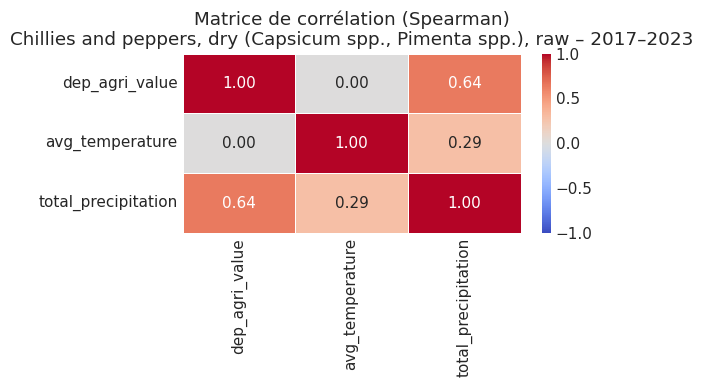

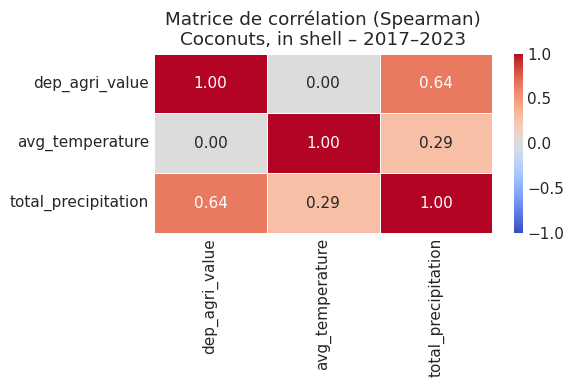

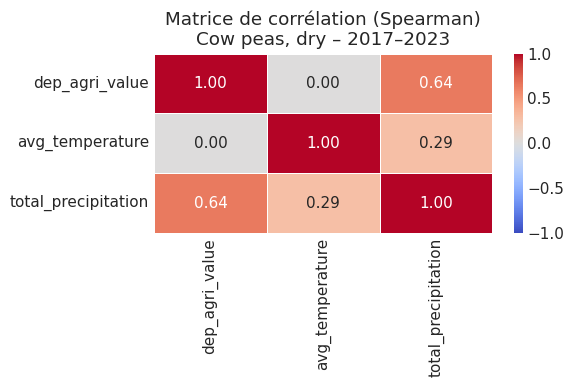

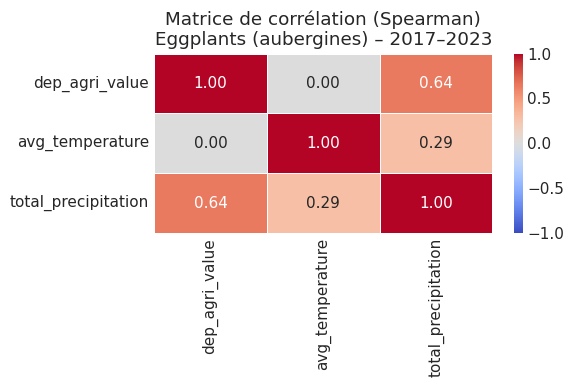

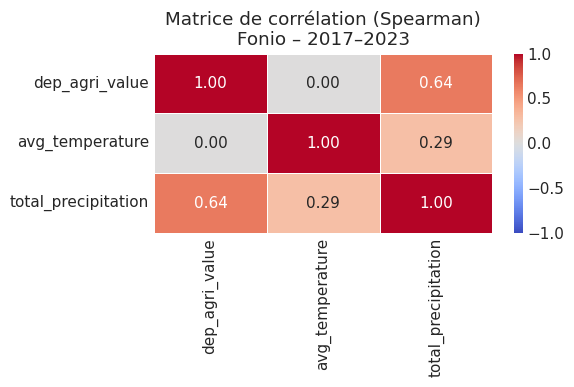

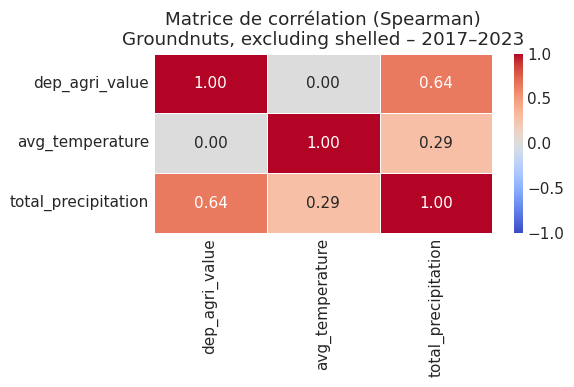

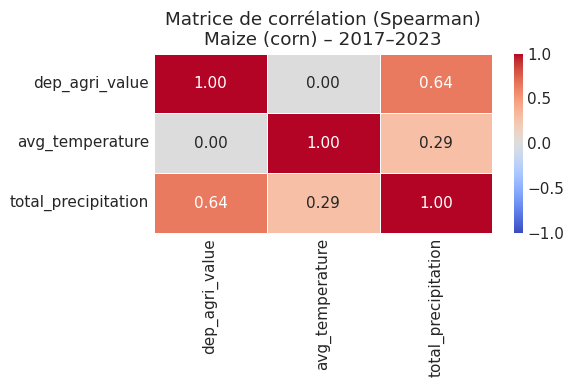

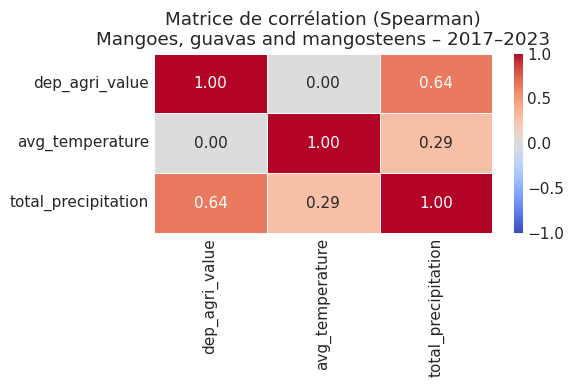

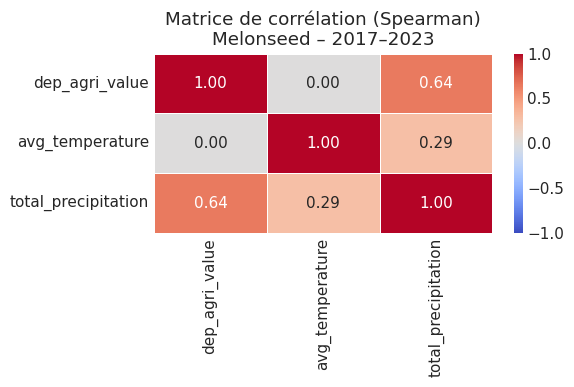

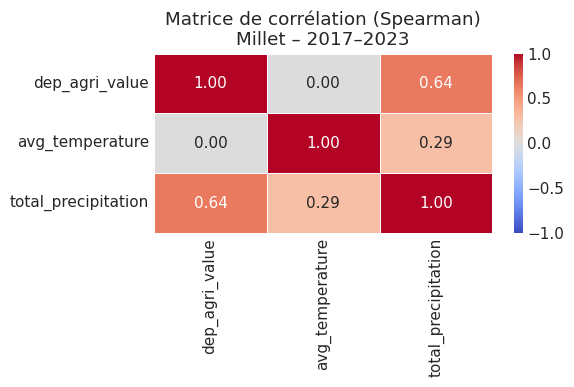

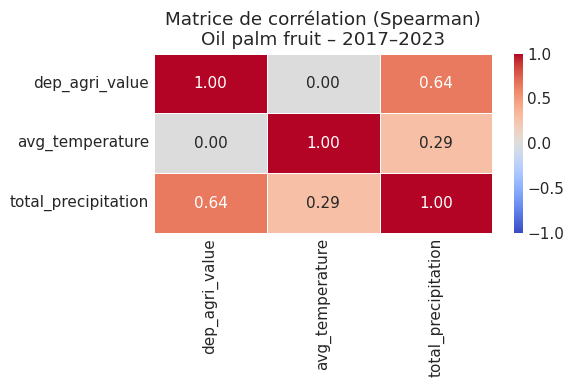

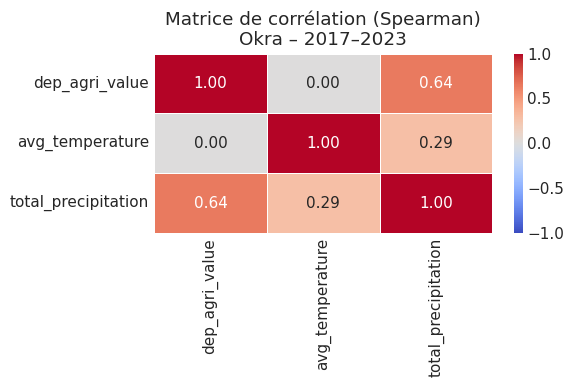

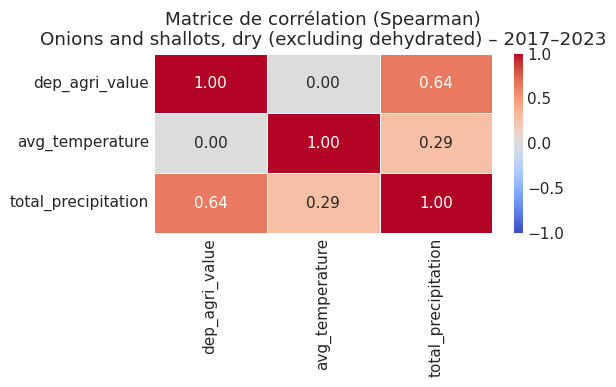

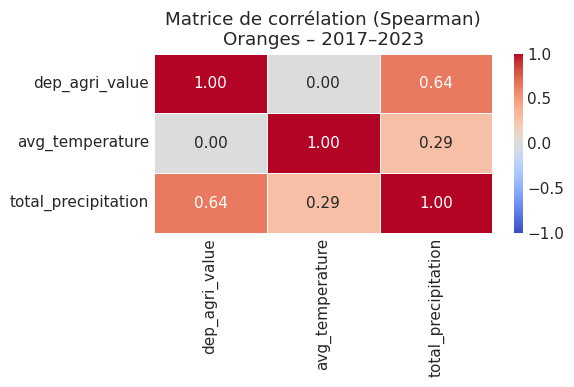

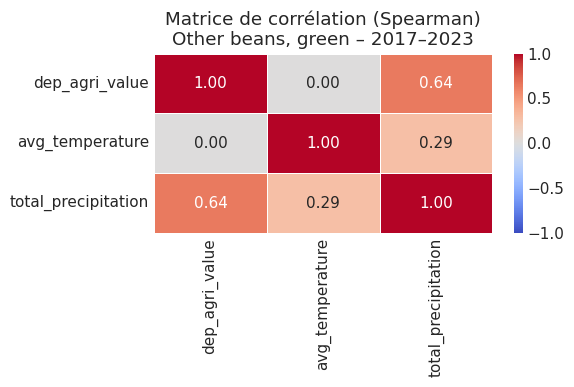

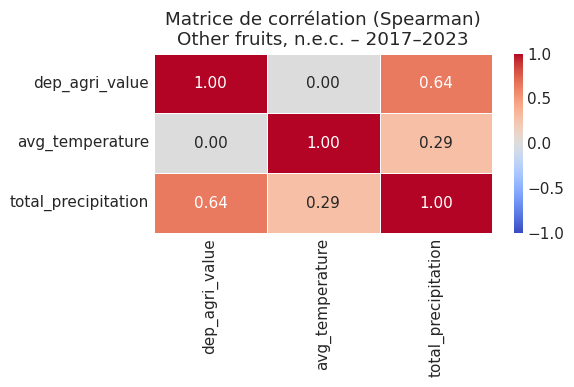

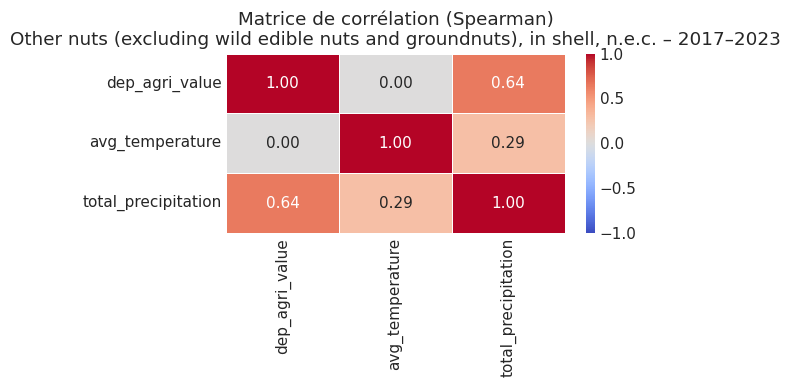

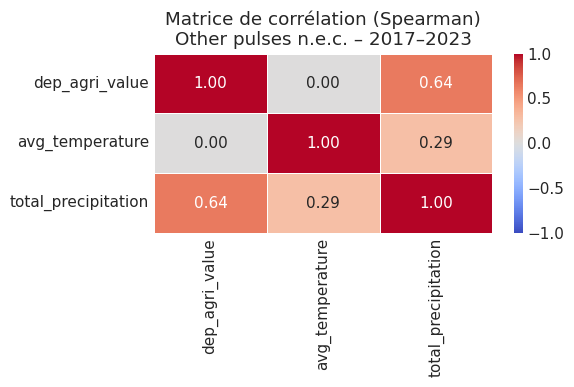

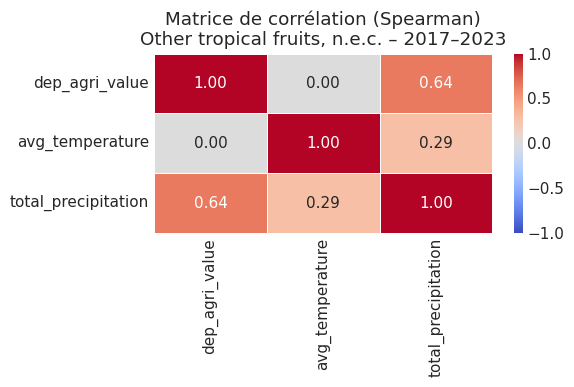

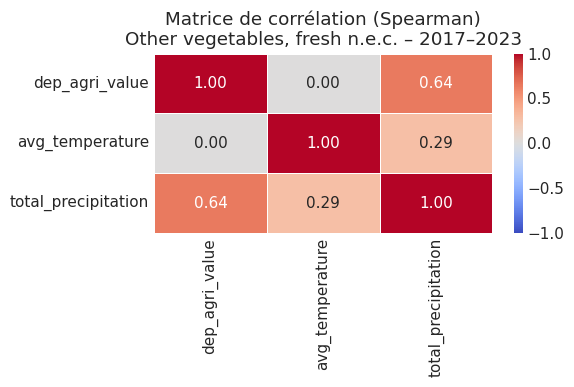

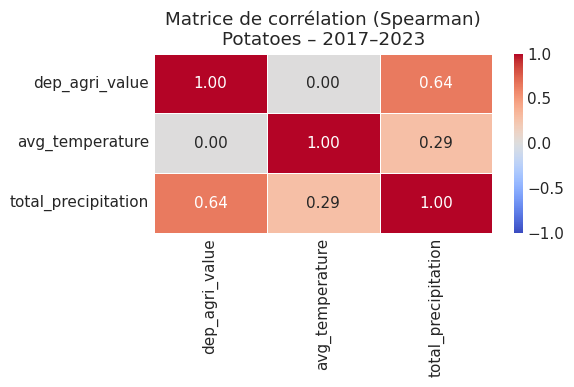

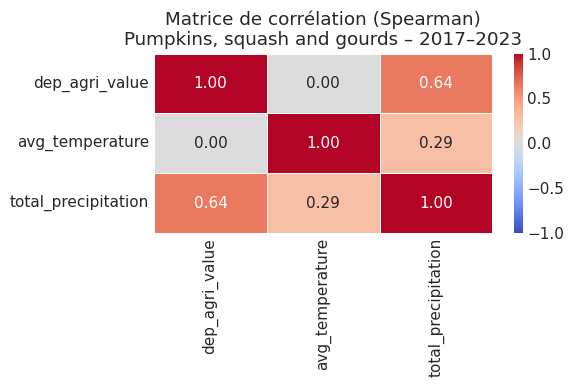

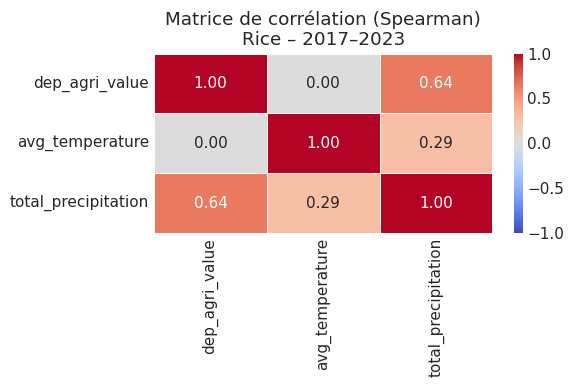

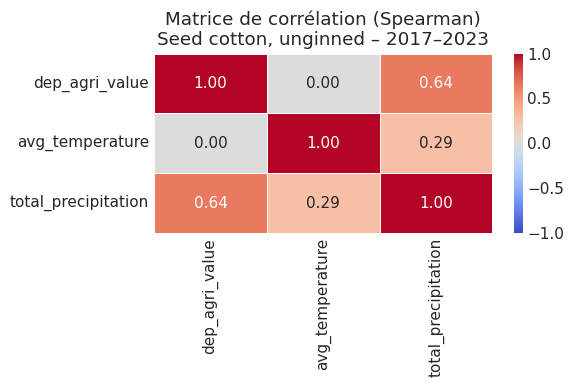

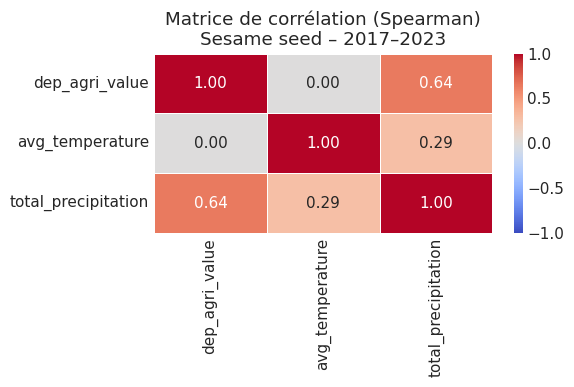

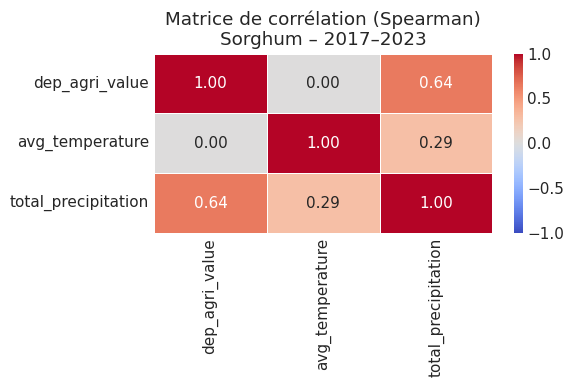

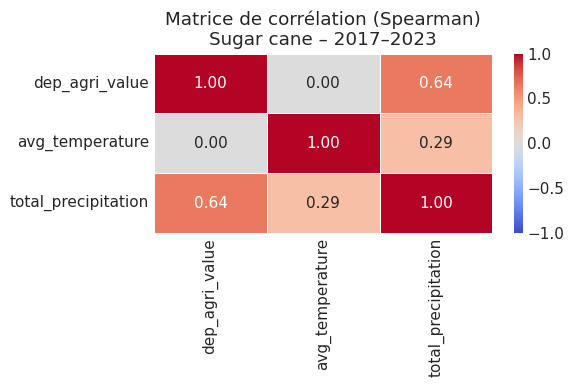

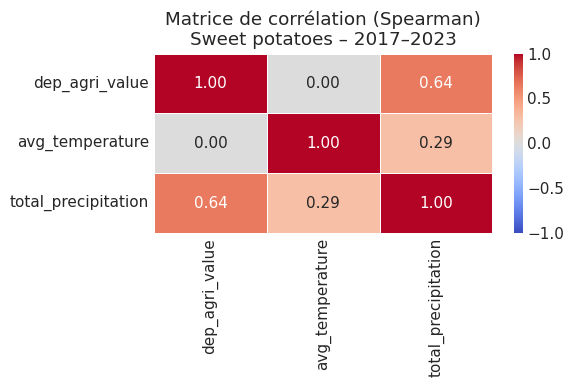

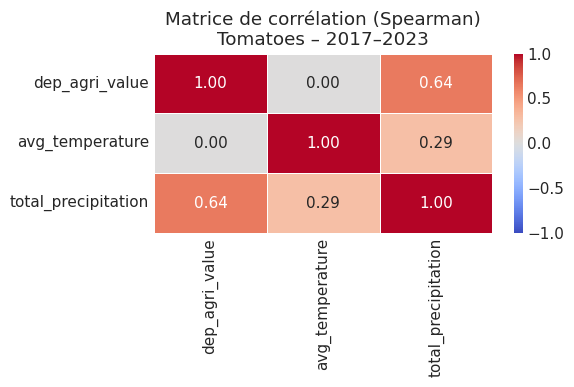

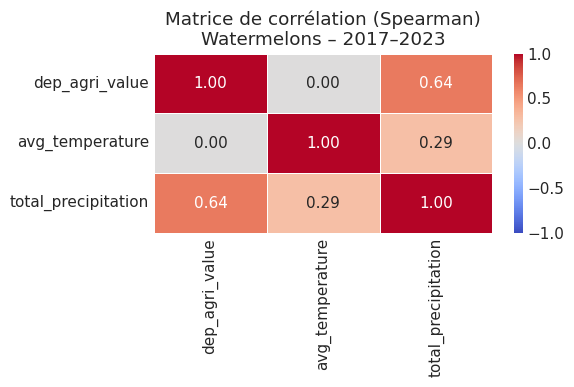

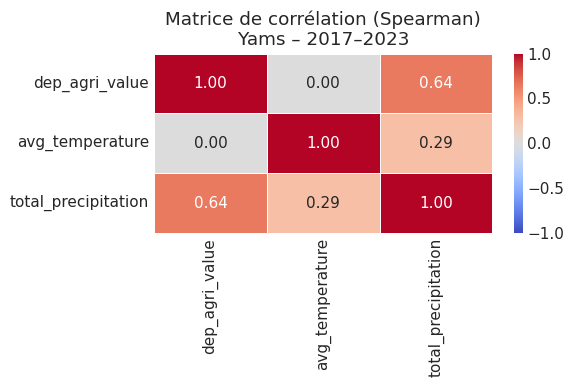

In [0]:

for culture in df_2017_2023['Item'].unique():
    
    df_culture = df_2017_2023[df_2017_2023['Item'] == culture][vars_corr].dropna()
    
    # Minimum d'observations
    if len(df_culture) < 4:
        continue
    
    corr_matrix = df_culture.corr(method='spearman')
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        vmin=-1,
        vmax=1,
        linewidths=0.5
    )
    
    plt.title(f"Matrice de corrélation (Spearman)\n{culture} – 2017–2023")
    plt.tight_layout()
    plt.show()


#### 5.3.4. Variante : matrice globale (toutes cultures confondues)

In [0]:
corr_global = df_2017_2023[vars_corr].dropna().corr(method='spearman')
print(corr_global)


                     dep_agri_value  avg_temperature  total_precipitation
dep_agri_value             1.000000         0.000000             0.642857
avg_temperature            0.000000         1.000000             0.285714
total_precipitation        0.642857         0.285714             1.000000


Cette matrice de corrélation montre que les dépenses agricoles sont modérément et positivement corrélées aux précipitations totales (r ≈ 0,64), suggérant que les années plus arrosées s’accompagnent généralement d’un niveau plus élevé d’investissement agricole, possiblement en lien avec l’intensification des activités de production. En revanche, la température moyenne n’entretient pratiquement aucune relation avec les dépenses agricoles (r = 0), indiquant une relative indépendance entre ces deux variables sur la période étudiée. Enfin, la corrélation entre température et précipitations demeure faible (r ≈ 0,29), traduisant une relation limitée et peu structurante entre les deux composantes climatiques. Globalement, ces résultats soulignent le rôle plus déterminant de la pluviométrie que de la température dans la dynamique des dépenses agricoles.

## Parite 6 : Effets des années de sécheresse sur les rendements agricoles par culture

### 6.1 Construction des rendements moyens par type d’année

In [0]:
from pyspark.sql.functions import avg, min, max, stddev, count, round, when

# Années de sécheresse identifiées
annees_seches = [2007, 2019]

# Calcul des statistiques de rendement par culture ET type d’année
rendements_impact_secheresse = df_rendement.withColumn(
    "type_annee",
    when(col("Year").isin(annees_seches), "Sèche").otherwise("Normale")
).groupBy("Item", "type_annee").agg(
    round(avg("Value"), 2).alias("Rendement_Moyen_kg_ha"),
    round(min("Value"), 2).alias("Rendement_Min"),
    round(max("Value"), 2).alias("Rendement_Max"),
    round(stddev("Value"), 2).alias("Ecart_Type"),
    count("*").alias("Nb_Observations")
)


### 6.2 Comparaison directe années Sèches vs Normales

In [0]:
# Pivot pour comparer directement
rendements_comparaison = rendements_impact_secheresse.groupBy("Item") \
    .pivot("type_annee") \
    .agg(avg("Rendement_Moyen_kg_ha"))

# Calcul de l'impact des sécheresses
rendements_comparaison = rendements_comparaison.withColumn(
    "Effet_Secheresse_kg_ha",
    round(col("Sèche") - col("Normale"), 2)
).orderBy("Normale", ascending=False)

rendements_comparaison.show(truncate=False)


+------------------------------------------------------------+---------+---------+----------------------+
|Item                                                        |Normale  |Sèche    |Effet_Secheresse_kg_ha|
+------------------------------------------------------------+---------+---------+----------------------+
|Sugar cane                                                  |114570.66|115493.55|922.89                |
|Sweet potatoes                                              |35571.52 |33199.1  |-2372.42              |
|Onions and shallots, dry (excluding dehydrated)             |29070.36 |29133.8  |63.44                 |
|Okra                                                        |26576.14 |23334.25 |-3241.89              |
|Bananas                                                     |25595.92 |24680.95 |-914.97               |
|Tomatoes                                                    |23764.94 |23998.2  |233.26                |
|Pumpkins, squash and gourds                  

La comparaison des rendements moyens entre années normales et années de sécheresse met en évidence des effets hétérogènes selon les cultures. Pour la majorité des cultures vivrières et maraîchères, les sécheresses de 2007 et 2019 s’accompagnent d’une baisse notable des rendements, traduisant une forte sensibilité au stress hydrique. C’est notamment le cas de l’okra (−3 242 kg/ha), des patates douces (−2 372 kg/ha), des haricots verts (−1 796 kg/ha) et du manioc frais (−1 534 kg/ha), qui apparaissent parmi les cultures les plus vulnérables.

À l’inverse, certaines cultures présentent une résilience relative, voire une légère amélioration des rendements en années sèches, comme la canne à sucre, les courges, les aubergines ou les carottes et navets.

## Conclusion

Cette étude a reposé sur l’analyse conjointe des données climatiques et agricoles annuelles sur la période 2005–2023, avec pour objectif d’évaluer l’influence effective du climat sur la production et les rendements agricoles, tout en identifiant les cultures les plus productives, les plus performantes et les plus vulnérables aux variations climatiques. L’analyse a montré que le climat s’était caractérisé par une stabilité thermique relative, la température moyenne annuelle s’étant établie autour de 28,2 °C, avec une amplitude limitée à environ 1,3 °C et une tendance faiblement haussière non significative. En revanche, les précipitations ont présenté une variabilité interannuelle très marquée, avec un écart-type de 1 805 mm, une moyenne de 4 416 mm, et des extrêmes dépassant 7 500 mm entre les années les plus humides et les plus sèches. L’application d’un seuil statistique de sécheresse fixé à 2 612 mm a permis d’identifier 2007 (1 702 mm) et 2019 (1 082 mm) comme les seules années strictement sèches de la période, confirmant l’existence de chocs hydriques ponctuels mais intenses.

Du point de vue agricole, la production totale s’est révélée fortement concentrée sur quelques cultures majeures. La canne à sucre s’est imposée comme la culture la plus produite en volume, suivie de l’arachide, du riz et du mil, ces dernières jouant un rôle central dans la sécurité alimentaire. L’analyse temporelle a montré une augmentation globale et significative de la production agricole, avec une croissance particulièrement marquée pour le riz et les pastèques, tandis que la canne à sucre et le mil ont affiché des progressions plus modérées mais structurelles. Cette dynamique a indiqué que l’augmentation de la production reposait à la fois sur l’extension des surfaces emblavées et sur des gains de productivité pour certaines cultures.

L’étude des rendements a mis en évidence des écarts structurels très importants entre cultures. La canne à sucre a affiché de loin les rendements moyens les plus élevés, confirmant son caractère intensif et industrialisé, et expliquant qu’elle puisse être à la fois la culture la plus produite et la plus productive, malgré une tendance légèrement décroissante de son rendement sur la période. Cette décroissance, bien que statistiquement significative, est restée marginale au regard du niveau absolu très élevé du rendement, traduisant davantage une stagnation que l’effondrement d’un système productif. À l’inverse, plusieurs cultures maraîchères, telles que la patate douce, l’okra et la pomme de terre, ont présenté des rendements élevés et en amélioration significative, illustrant des gains d’efficacité notables. Les cultures céréalières traditionnelles — mil, sorgho, maïs et fonio — ont affiché des rendements moyens plus faibles, traduisant des contraintes structurelles persistantes, malgré leur importance stratégique.

Les analyses de corrélation climat–agriculture ont montré que, globalement, les relations entre climat moyen annuel et performances agricoles étaient faibles, confirmant que les évolutions de la production ne pouvaient être expliquées par le seul climat. Toutefois, l’analyse par culture a révélé des sensibilités climatiques spécifiques et parfois marquées. Le maïs a présenté une corrélation positive significative avec les précipitations (Spearman ≈ 0,46, p < 0,05), indiquant une forte dépendance à la disponibilité en eau. Le mil a affiché un comportement similaire (Spearman ≈ 0,48, p < 0,05), confirmant sa vulnérabilité aux déficits pluviométriques. À l’opposé, la canne à sucre a montré des corrélations faibles et non significatives avec la température et les précipitations, traduisant une résilience climatique relative, probablement liée à l’irrigation et à la maîtrise technique. L’igname s’est distinguée comme l’une des cultures les plus vulnérables, avec une corrélation négative significative avec la température (Spearman ≈ –0,64, p ≈ 0,048), suggérant une sensibilité élevée aux épisodes de chaleur. Certaines cultures maraîchères, comme les aubergines et les piments, ont présenté des corrélations positives significatives avec la température, indiquant une réponse favorable à des conditions plus chaudes dans certaines limites.

L’analyse comparative entre années normales et années de sécheresse a renforcé ces constats. Les années 2007 et 2019 ont été associées à des baisses de rendement marquées pour plusieurs cultures vivrières et pluviales, confirmant leur vulnérabilité au stress hydrique. En revanche, des cultures comme la canne à sucre, le manioc ou la banane ont montré une stabilité relative des rendements, soulignant leur capacité d’adaptation ou leur moindre dépendance directe aux précipitations annuelles. L’ensemble des résultats a mis en évidence que les cultures les plus produites n’étaient pas nécessairement les plus vulnérables, et que les cultures à haut rendement pouvaient, comme dans le cas de la canne à sucre, connaître des dynamiques de stagnation ou de légère décroissance sans remettre en cause leur dominance productive.